# Overview
**DayCent regional simulation results post-processing**

This Jupyter Notebook is designed to facilitate post-processing and analysis of sets of raw DayCent results from a regional scale simulation. For more information, contact author [John Field](https://johnlfield.weebly.com/) at <john.L.field@gmail.com>

## DayCent background

DayCent is a process-based model that simulates agro-ecosystem net primary production, soil organic matter dynamics, and nitrogen (N) cycling and trace gas emissions. DayCent is a daily-timestep version of the older CENTURY model. Both models were created and are currently maintained at the Colorado State University [Natural Resource Ecology Laboratory](https://www.nrel.colostate.edu/) (CSU-NREL), and source code is available upon request.  DayCent model homepage:  [https://www2.nrel.colostate.edu/projects/daycent/](https://www2.nrel.colostate.edu/projects/daycent/)

## Regional workflow

The primary spatial data inputs to DayCent are:
* soil texture as a function of depth
* historic daily weather (Tmin, Tmax, precip)

Our DayCent spatial modeling workflow is based on a national-scale GIS database of current land use ([NLCD](https://www.mrlc.gov/national-land-cover-database-nlcd-2016)), soil ([SSURGO](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/survey/?cid=nrcs142p2_053627)), and weather ([NARR](https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/north-american-regional-reanalysis-narr)) data layers housed at CSU-NREL. The python-based workflow consists of a collection of scripts that perform the following:
1. Selection of area to be simulated, specified based on current land cover and/or land biophysical factors (i.e., soil texutre, slope, land capability class rating, etc.)
2. Determination of individual unique DayCent model runs (i.e., **"strata"**) necessary to cover the heterogenity of soils and climate across the simulation area
3. Parallel execution of simulations on the CSU-NREL computing cluster
4. Results analysis and mapping (this routine)

### TODO: add a section about these specific simulaions– the origin of the calibration, and the land use assumptions

## Simulating switchgrass on abandoned cropland

Simulating rainfed switchgrass, fertilized at 75 kg N ha-1 y-1, and replanted every 10 years. Amounts of abandoned cropland, and the date of peak cropland, for every county were taken from Zumkehr & Campbell 2013. Abandoned cropland randomly assigned (at 4km scale) to available X, Y & Z in each pixel as per the National Land Cover Database. Assumed unfertilized native grass during period of abandonment. 



>Zumkehr, A., & Campbell, J. E. (2013). Historical U.S. cropland areas and the potential for bioenergy production on abandoned croplands. Environmental Science & Technology, 47(8), 3840–3847. https://doi.org/10.1021/es3033132

Simuated yields of switchgrass and other energy crops can be compared against those from PRISM-EM, a hybrid modeling approach that combines PRISM climate data, biophysical limits to prodcutivity, and expert judgement. PRISM-EM energy grass results are described in:

>Lee, D. K., Aberle, E., Anderson, E. K., Anderson, W., Baldwin, B. S., Baltensperger, D., Barrett, M., Blumenthal, J., Bonos, S., Bouton, J., Bransby, D. I., Brummer, C., Burks, P. S., Chen, C., Daly, C., Egenolf, J., Farris, R. L., Fike, J. H., Gaussoin, R., … Owens, V. (2018). Biomass production of herbaceous energy crops in the United States: Field trial results and yield potential maps from the multiyear regional feedstock partnership. GCB Bioenergy, 10(10), 698–716. https://doi.org/10.1111/gcbb.12493

And PRISM-EM results for energy tree crops are described in:

>Volk, T. A., Berguson, B., Daly, C., Halbleib, M. D., Miller, R., Rials, T. G., Abrahamson, L. P., Buchman, D., Buford, M., Cunningham, M. W., Eisenbies, M., Fabio, E. S., Hallen, K., Heavey, J., Johnson, G. A., Kuzovkina, Y. A., Liu, B., Mcmahon, B., Rousseau, R., … Wright, J. (2018). Poplar and shrub willow energy crops in the United States: Field trial results from the multiyear regional feedstock partnership and yield potential maps based on the PRISM‐ELM model. GCB Bioenergy, 10(10), 735–751. https://doi.org/10.1111/gcbb.12498

# Data structures & flow

Listen in the order in which they are introduced. 

- run_df = DayCent simulation runtable
- lis_df = all concatenated DayCent .lis simulation timeseries
- ys_df = all concatenated DayCent year_summary.out simulation timeseries
- df = merged lis_df & ys_df simulation timeseries (filtering & unit conversion applied to this dataframe)
- area_df = strata areas (from run_df) merged to simulation timeseries (df)
- area_tot_df = intermediate dataframe for timeseries production & flux totals across strata area (intermediate step in area-weighting)
- annual_df (saved output) = county-level (area-weighted) timeseries production & fluxes
- county_df (saved output) = county-level mean, STD & COV production & fluxes
- norm_df (saved output) = normalized county-level yield time-series (for exploring regional precip sensitivity)
- reg_df (saved output) = r2 values capturing strength of yield–precip relationship in each county
- frr_df = mapping Farm Resource Regions by county
- cabbi_df = county-average Miscanthus yield data from Jeff Kent circa Nov 2021
- coa_df = USDA Census of Agriculture cropland area data

In [1]:
# start a timer to track total notebook execution time

from datetime import datetime
start_time = datetime.now()

# Code & data imports

## Load python modules

In [2]:
import constants as con
from IPython.display import Image, display
import json
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm

## Load runtable

Individual DayCent strata are specified via a .csv format "runtable" file, which contains the following information:
* unique identifier (strata_no)
* ID for DayCent spin-up archive (runno)
* SSURGO soil map unit ID (mukey_int)
* NARR climate grid ID (gridx & gridy)
* county FIPS code (fips)
* DayCent-format schedule file to simulate (sch_file)
* latitude of the county centroid, used to set perennial grass phenology (latitude)
* for simulations on abandoned agricultural land, year of peak ag land extent (peak_year)
* land area represented by that strata (tot_ha)
The code below loads the relevant runtable to a Pandas dataframe.

In [3]:
runtable = "01_raw_inputs/ContUS_runtable_incl81.csv"
run_df = pd.read_csv(runtable, skiprows=[1])   # skip SQL datatype row
run_df

strata_no    runno  mukey_int  gridx  gridy   fips  \
0               1     8942     328058     89    234   1001   
1               2    17925     328059     89    234   1001   
2               3    27012     328060     89    234   1001   
3               4    36132     328061     89    234   1001   
4               5    45302     328062     89    234   1001   
...           ...      ...        ...    ...    ...    ...   
511039     568862  4490928    2516980    122    181  56045   
511040     568863  4490985    2516988    122    181  56045   
511041     568864  4490997    2516989    122    181  56045   
511042     568865  4491000    2516990    122    181  56045   
511043     568866  4491064    2517214    122    181  56045   

                      sch_file   latitude  peak_year      tot_ha  
0       idle_switchgrass75.sch  32.534931       1950  165.751842  
1       idle_switchgrass75.sch  32.534931       1950   17.960497  
2       idle_switchgrass75.sch  32.534931       1950  235.329205  
3       idle_switchgrass75.sch  32.534931       1950    2.221341  
4       idle_switchgrass75.sch  32.534931       1950   63.330603  
...                        ...        ...        ...         ...  
511039  idle_switchgrass75.sch  43.840485       2000    1.026365  
511040  idle_switchgrass75.sch  43.840485       2000    5.069576  
511041  idle_switchgrass75.sch  43.840485       2000   57.401776  
511042  idle_switchgrass75.sch  43.840485       2000   25.088445  
511043  idle_switchgrass75.sch  43.840485       2000   63.694119  

[511044 rows x 10 columns]

In [4]:
# extract the total count of strata & counties simulated

run_strata = len(run_df.strata_no.unique())
print('Target strata:', run_strata)

run_counties = len(run_df.fips.unique())
print('Target counties:', run_counties)

Target strata: 511044
Target counties: 2887


## Load DayCent results

Raw DayCent model output is spread across two files:
* .lis files contain information related to per-area biomass harvest and soil carbon
* year_summary.out contains per-area trace gas emissions

First, we load and concatenate the .lis output for the relevant switchgrass variety scenarios. 

In [5]:
# specify & explore .lis output

results_path = '/Users/53f/Desktop/daycent_data/'

# specify the "base" simulation results which will be analyzed
# (earlier versions of this code also considered an alterative set of "treatment" results)
base_sims = '2021-09-13,23.00__ContUS_runtable_incl81__79__ABM_ContUS'
base_lis_fpath = os.path.join(results_path, base_sims+'/X.lis')

# read the first few rows
with open(base_lis_fpath) as myfile:
    head = [next(myfile) for x in range(5)]
head

['strata_no,crop,land_type,time,cgrain,crmvst,shrema,somsc,strmac(2),volpac,bglivcj,bglivcm,prcann,irrtot,ermvst(1),snfxac(1),wdfxaa,wdfxas,strmac(6),d_somsc\n',
 'INT,TEXT,TEXT,INT,REAL,REAL,REAL,REAL,REAL,REAL,REAL,REAL,REAL,REAL,REAL,REAL,REAL,REAL,REAL,REAL\n',
 '1,idle,switchgrass75,1975,0.0,0.0,0.0,2045.027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0\n',
 '1,idle,switchgrass75,1976,0.0,0.0,165.812,2069.303,1.791,1.053,70.092,63.722,155.117,0.0,0.0,6.084,1.5,1.0,0.014559,24.276\n',
 '1,idle,switchgrass75,1977,0.0,0.0,81.098,2108.282,0.395,0.587,39.844,57.041,127.419,0.0,0.0,2.955,1.5,0.622,0.022301,38.979\n']

In [6]:
# to save time & memory, only upload the specific data columns that will be used in subsequent analysis
lis_cols = ['strata_no', 'time', 'crmvst', 'somsc', 'strmac(2)', 'volpac', 'd_somsc']

# .lis data import, skipping SQL datatype rows
base_lis_df = pd.read_csv(base_lis_fpath, skiprows=[1], usecols=lis_cols)
base_lis_df['variety'] = 'base'

lis_df = base_lis_df

Note that my DayCent workflow has an indexing issue with the .lis output. In this output, year 2022 is a dummy row, and the real 2022 results show up in the 2023 row, with all subsequent results frame-shifted accordingly. Thus, we have to drop the 2022 row, and shift the time index in all subsequent rows:

In [7]:
lis_df = lis_df[lis_df.time != 2021].copy()
lis_df['time'] = np.where(lis_df['time'] > 2021, lis_df['time'] - 1, lis_df['time'])
lis_df

strata_no  time   crmvst     somsc  strmac(2)  volpac  d_somsc  \
0                 1  1975    0.000  2045.027      0.000   0.000    0.000   
1                 1  1976    0.000  2069.303      1.791   1.053   24.276   
2                 1  1977    0.000  2108.282      0.395   0.587   38.979   
3                 1  1978    0.000  2154.458      0.201   0.627   46.176   
4                 1  1979    0.000  2225.041      0.374   0.693   70.583   
...             ...   ...      ...       ...        ...     ...      ...   
46303865     568820  2067  462.695  4617.464      8.813   0.580   -0.940   
46303866     568820  2068  443.245  4633.086     12.145   0.561   15.622   
46303867     568820  2069  537.026  4644.980      0.000   0.666   11.894   
46303868     568820  2070  577.326  4653.722      7.920   0.703    8.742   
46303869     568820  2071  301.719  4672.140      4.701   0.400   18.418   

         variety  
0           base  
1           base  
2           base  
3           base  
4           base  
...          ...  
46303865    base  
46303866    base  
46303867    base  
46303868    base  
46303869    base  

[45792826 rows x 8 columns]

Then, we do the same for the year_summary.out results.

In [8]:
ys_cols = ['strata_no', 'time', 'N2Oflux', 'NOflux', 'CH4', 'ANNPPT']

# year_summary.out data import, skipping SQL datatype rows
base_ys_fpath = os.path.join(results_path, base_sims+'/year_summary.out')
base_ys_df = pd.read_csv(base_ys_fpath, skiprows=[1], usecols=ys_cols)
base_ys_df['variety'] = 'base'

ys_df = base_ys_df
ys_df

strata_no  time   N2Oflux    NOflux       CH4      ANNPPT variety
0                 1  1975  0.071433  0.054203  0.221034  155.116943    base
1                 1  1976  0.013492  0.030303  0.247949  127.418991    base
2                 1  1977  0.020945  0.032218  0.246919  118.088013    base
3                 1  1978  0.022181  0.041216  0.216468  144.686279    base
4                 1  1979  0.020329  0.039546  0.214066  173.853271    base
...             ...   ...       ...       ...       ...         ...     ...
45792821     568820  2067  0.171823  0.088472  0.202949   57.304409    base
45792822     568820  2068  0.199013  0.081792  0.207332   63.666538    base
45792823     568820  2069  0.115536  0.112198  0.220917   59.125423    base
45792824     568820  2070  0.161654  0.104471  0.189069   77.159653    base
45792825     568820  2071  0.148002  0.083664  0.182980   57.734756    base

[45792826 rows x 7 columns]

# DayCent results analysis

## Merge .lis & .out data

In [9]:
# merge .lis & year_summary.out DataFrames
df = pd.merge(lis_df, ys_df, on=['strata_no', 'variety', 'time'], validate='1:1')
df

strata_no  time   crmvst     somsc  strmac(2)  volpac  d_somsc  \
0                 1  1975    0.000  2045.027      0.000   0.000    0.000   
1                 1  1976    0.000  2069.303      1.791   1.053   24.276   
2                 1  1977    0.000  2108.282      0.395   0.587   38.979   
3                 1  1978    0.000  2154.458      0.201   0.627   46.176   
4                 1  1979    0.000  2225.041      0.374   0.693   70.583   
...             ...   ...      ...       ...        ...     ...      ...   
45792821     568820  2067  462.695  4617.464      8.813   0.580   -0.940   
45792822     568820  2068  443.245  4633.086     12.145   0.561   15.622   
45792823     568820  2069  537.026  4644.980      0.000   0.666   11.894   
45792824     568820  2070  577.326  4653.722      7.920   0.703    8.742   
45792825     568820  2071  301.719  4672.140      4.701   0.400   18.418   

         variety   N2Oflux    NOflux       CH4      ANNPPT  
0           base  0.071433  0.054203  0.221034  155.116943  
1           base  0.013492  0.030303  0.247949  127.418991  
2           base  0.020945  0.032218  0.246919  118.088013  
3           base  0.022181  0.041216  0.216468  144.686279  
4           base  0.020329  0.039546  0.214066  173.853271  
...          ...       ...       ...       ...         ...  
45792821    base  0.171823  0.088472  0.202949   57.304409  
45792822    base  0.199013  0.081792  0.207332   63.666538  
45792823    base  0.115536  0.112198  0.220917   59.125423  
45792824    base  0.161654  0.104471  0.189069   77.159653  
45792825    base  0.148002  0.083664  0.182980   57.734756  

[45792826 rows x 12 columns]

In [10]:
# check no. of strata in merged results for consistency w/ runtable

print("Unique runtable strata count:", run_df.strata_no.nunique())
print("Unique DayCent output strata count:", df.strata_no.nunique())

Unique runtable strata count: 511044
Unique DayCent output strata count: 511044


## Unit conversions

Most DayCent outputs are in units of grams of carbon per meter squared (g C m-2), though some of the nitrogen flux results are reported on a per-hectare basis instead. The code below performs basic unit converions to express the results in more familiar units of kg or Mg per hectare. 

In [11]:
# unit conversions
df['yield_Mg_per_ha'] = ((df['crmvst'] * con.g_m2_to_Mg_ha) / con.c_concentration)
df['SOC_MgC_per_ha'] = (df['somsc'] * con.g_m2_to_Mg_ha)
df['dSOC_MgC_per_ha'] = (df['d_somsc'] * con.g_m2_to_Mg_ha)
df['dN2ON_kgN_per_ha'] = (df['N2Oflux'] * con.g_m2_to_kg_ha)
df['iN2ON_kgN_per_ha'] = ((0.0075 * df['strmac(2)'] + 0.01 * df['volpac'] +
                           0.01 * df['NOflux']) * con.g_m2_to_kg_ha)
df['kgCH4_ox_per_ha'] = (df['CH4'] * con.g_m2_to_kg_ha)
df['ghg_MgCO2e_per_ha'] = (df['dSOC_MgC_per_ha'] * con.c_to_co2 * -1.0) + \
                           ((df['dN2ON_kgN_per_ha'] + df['iN2ON_kgN_per_ha']) *
                            con.kg_ha_to_Mg_ha * con.n_to_n2o * con.n2o_gwp100_ar5) + \
                    (df['kgCH4_ox_per_ha'] * con.kg_ha_to_Mg_ha * con.ch4_gwp100_ar5 * -1.0)
df['volit_kgN_per_ha'] = df['volpac'] * con.g_m2_to_kg_ha
df['leached_kgN_per_ha'] = df['strmac(2)'] * con.g_m2_to_kg_ha

# rename annual precipitation data column
df.rename(columns={'ANNPPT': 'annual_precip_cm'}, inplace=True)

# drop the original columns with non-standard unit data
df.drop(columns=['crmvst', 'somsc', 'd_somsc', 'N2Oflux',
                 'strmac(2)', 'volpac', 'NOflux', 'CH4'], inplace=True)

## Extract initial SOC values

In [12]:
# select the row with the lowest 'time' value in each strata_no group, and propagate the associated SOC values

init_SOC_df = df[['strata_no', 'time', 'SOC_MgC_per_ha']].loc[df.groupby('strata_no').time.idxmin()]
init_SOC_df.rename(columns={'SOC_MgC_per_ha': 'initSOC_MgC_per_ha'}, inplace=True)
init_SOC_df

strata_no  time  initSOC_MgC_per_ha
0                 1  1975            20.45027
653951            2  1975            20.47634
1307770           3  1975            13.78600
1961900           4  1975            16.73005
2615636           5  1975            13.23958
...             ...   ...                 ...
26164266     568862  2000            16.47487
26818691     568863  2000            46.74890
27473614     568864  2000            46.74890
28127011     568865  2000            43.04020
28781105     568866  2000            31.89658

[511044 rows x 3 columns]

In [13]:
# reassociate these strata-level initial SOC results with the main dataframe

df = df.merge(init_SOC_df[['strata_no', 'initSOC_MgC_per_ha']], on='strata_no') 

Plotting strata 1
   strata_no  time  initSOC_MgC_per_ha
0          1  1975            20.45027

Plotting strata 59105
          strata_no  time  initSOC_MgC_per_ha
13146769      59105  1978             9.61325

Plotting strata 113854
          strata_no  time  initSOC_MgC_per_ha
26293639     113854  1985            43.58203

Plotting strata 167197
          strata_no  time  initSOC_MgC_per_ha
39443192     167197  1985            57.29679

Plotting strata 223846
         strata_no  time  initSOC_MgC_per_ha
6793640     223846  1975            31.09739

Plotting strata 280412
          strata_no  time  initSOC_MgC_per_ha
19938846     280412  1985            33.35626

Plotting strata 336336
          strata_no  time  initSOC_MgC_per_ha
33091426     336336  1975            54.41727

Plotting strata 390841
        strata_no  time  initSOC_MgC_per_ha
445889     390841  1995            44.65161

Plotting strata 446324
          strata_no  time  initSOC_MgC_per_ha
13592262     446324  1975    

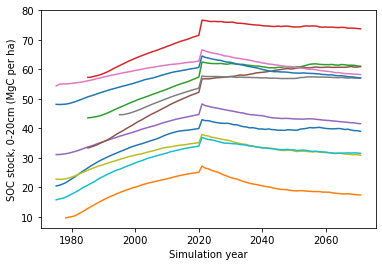

In [14]:
# iterate through the list of distinct strata

all_strata = df.strata_no.unique()
all_strata.sort()

for i, strata in enumerate(all_strata):

    # plot only one result for every X rows of strata results
    divisor = 50000
    if i % divisor == 0:

        print('Plotting strata', strata)
        print(init_SOC_df[init_SOC_df.strata_no == strata])
        strata_df = df[df.strata_no == strata]
        plt.plot(strata_df['time'], strata_df['SOC_MgC_per_ha'], label=str(strata))
        print()

# plt.legend(title='Strata')
plt.xlabel('Simulation year')
plt.ylabel('SOC stock, 0-20cm (MgC per ha)')
plt.savefig('03_figure_outputs/Representative_SOC_traces.png')
plt.show()

In [15]:
# drop all results prior to the start of switchgrass harvest, and stop after a single loop through the 35-year NARR record
start_y = 2022
end_y = 2056
df = df[df['time'].between(start_y, end_y)].copy()

print('Target nubmber of rows:', ((end_y - start_y) + 1) * run_strata)
df

Target nubmber of rows: 17886540


strata_no  time variety  annual_precip_cm  yield_Mg_per_ha  \
47                1  2022    base        127.418991        18.416044   
48                1  2023    base        118.088013        19.773111   
49                1  2024    base        144.686279        24.553822   
50                1  2025    base        173.853271        23.795489   
51                1  2026    base        120.961884        23.472867   
...             ...   ...     ...               ...              ...   
45792806     568820  2052    base         43.149998         8.588333   
45792807     568820  2053    base         40.411968         6.402889   
45792808     568820  2054    base         25.844015         2.523378   
45792809     568820  2055    base         72.558998         6.940889   
45792810     568820  2056    base         52.826633        13.479400   

          SOC_MgC_per_ha  dSOC_MgC_per_ha  dN2ON_kgN_per_ha  iN2ON_kgN_per_ha  \
47              42.62157         -0.32417           0.96583          0.316530   
48              42.61322         -0.00835           1.39245          0.292983   
49              42.33291         -0.28031           1.49457          0.592345   
50              42.06903         -0.26388           1.53773          0.543141   
51              41.89829         -0.17074           1.44464          0.314799   
...                  ...              ...               ...               ...   
45792806        44.73984          0.18295           0.77198          0.058710   
45792807        44.88032          0.14048           0.72301          0.262260   
45792808        45.02271          0.14239           0.53430          0.027828   
45792809        45.03304          0.01033           2.69982          0.052520   
45792810        45.04159          0.00855           1.98978          0.666684   

          kgCH4_ox_per_ha  ghg_MgCO2e_per_ha  volit_kgN_per_ha  \
47                2.21261           1.659727              8.26   
48                2.39050           0.665380             10.79   
49                2.02627           1.839210             13.09   
50                1.97604           1.777899             12.73   
51                2.14398           1.298101             12.58   
...                   ...                ...               ...   
45792806          2.43910          -0.392782              5.04   
45792807          2.42979          -0.172550              3.91   
45792808          2.61923          -0.361025              1.96   
45792809          1.88521           1.055283              4.12   
45792810          1.67848           1.027676              7.53   

          leached_kgN_per_ha  initSOC_MgC_per_ha  
47                     29.62            20.45027  
48                     23.18            20.45027  
49                     59.65            20.45027  
50                     53.67            20.45027  
51                     23.52            20.45027  
...                      ...                 ...  
45792806                0.00            28.89902  
45792807               28.70            28.89902  
45792808                0.00            28.89902  
45792809                0.00            28.89902  
45792810               77.44            28.89902  

[17886540 rows x 14 columns]

In [16]:
# re-associate FIPS codes and land areas with strata results

area_df = pd.merge(run_df[['strata_no', 'fips', 'tot_ha']], df, on='strata_no', validate='1:m')
area_df

strata_no   fips      tot_ha  time variety  annual_precip_cm  \
0                 1   1001  165.751842  2022    base        127.418991   
1                 1   1001  165.751842  2023    base        118.088013   
2                 1   1001  165.751842  2024    base        144.686279   
3                 1   1001  165.751842  2025    base        173.853271   
4                 1   1001  165.751842  2026    base        120.961884   
...             ...    ...         ...   ...     ...               ...   
17886535     568866  56045   63.694119  2052    base         43.149998   
17886536     568866  56045   63.694119  2053    base         40.411968   
17886537     568866  56045   63.694119  2054    base         25.844015   
17886538     568866  56045   63.694119  2055    base         72.558998   
17886539     568866  56045   63.694119  2056    base         52.826633   

          yield_Mg_per_ha  SOC_MgC_per_ha  dSOC_MgC_per_ha  dN2ON_kgN_per_ha  \
0               18.416044        42.62157         -0.32417           0.96583   
1               19.773111        42.61322         -0.00835           1.39245   
2               24.553822        42.33291         -0.28031           1.49457   
3               23.795489        42.06903         -0.26388           1.53773   
4               23.472867        41.89829         -0.17074           1.44464   
...                   ...             ...              ...               ...   
17886535        10.144133        50.05745          0.24174           0.83483   
17886536         8.222422        50.25129          0.19384           0.81896   
17886537         3.255178        50.39929          0.14800           0.58433   
17886538         8.099222        50.40799          0.00870           2.44025   
17886539        15.981444        50.38747         -0.02052           2.30049   

          iN2ON_kgN_per_ha  kgCH4_ox_per_ha  ghg_MgCO2e_per_ha  \
0                 0.316530          2.21261           1.659727   
1                 0.292983          2.39050           0.665380   
2                 0.592345          2.02627           1.839210   
3                 0.543141          1.97604           1.777899   
4                 0.314799          2.14398           1.298101   
...                    ...              ...                ...   
17886535          0.069734          2.63418          -0.582897   
17886536          0.060198          2.66103          -0.418718   
17886537          0.034361          2.96384          -0.367680   
17886538          0.062720          2.07905           0.952004   
17886539          0.256812          1.57554           1.095787   

          volit_kgN_per_ha  leached_kgN_per_ha  initSOC_MgC_per_ha  
0                     8.26               29.62            20.45027  
1                    10.79               23.18            20.45027  
2                    13.09               59.65            20.45027  
3                    12.73               53.67            20.45027  
4                    12.58               23.52            20.45027  
...                    ...                 ...                 ...  
17886535              5.82                0.00            31.89658  
17886536              4.86                0.00            31.89658  
17886537              2.33                0.00            31.89658  
17886538              4.70                0.00            31.89658  
17886539              8.70               20.56            31.89658  

[17886540 rows x 16 columns]

First, we combine the total production and impacts associated with each strata in each year by multiplying the per-ha results with the area represented by each strata:

In [17]:
# calculate strata totals & drop obsolete data
area_tot_df = area_df.copy(deep=False)

weight_cols = ['yield_Mg', 'initSOC_MgC', 'SOC_MgC', 'dSOC_MgC', 'dN2ON_kgN', 'iN2ON_kgN',
               'kgCH4_ox', 'ghg_MgCO2e', 'volit_kgN', 'leached_kgN']

for col in weight_cols:
    area_tot_df[col] = area_tot_df[col+'_per_ha'] * area_tot_df['tot_ha']
    area_tot_df.drop(columns=[col+'_per_ha'], inplace=True)

area_tot_df['annual_precip_cm_ha'] = area_tot_df['annual_precip_cm'] * area_tot_df['tot_ha']
area_tot_df.drop(columns=['annual_precip_cm'], inplace=True)

area_tot_df

strata_no   fips      tot_ha  time variety     yield_Mg  \
0                 1   1001  165.751842  2022    base  3052.493289   
1                 1   1001  165.751842  2023    base  3277.429589   
2                 1   1001  165.751842  2024    base  4069.841261   
3                 1   1001  165.751842  2025    base  3944.146115   
4                 1   1001  165.751842  2026    base  3890.670887   
...             ...    ...         ...   ...     ...          ...   
17886535     568866  56045   63.694119  2052    base   646.121636   
17886536     568866  56045   63.694119  2053    base   523.719939   
17886537     568866  56045   63.694119  2054    base   207.335681   
17886538     568866  56045   63.694119  2055    base   515.872824   
17886539     568866  56045   63.694119  2056    base  1017.924024   

          initSOC_MgC      SOC_MgC   dSOC_MgC   dN2ON_kgN  iN2ON_kgN  \
0         3389.669922  7064.603736 -53.731775  160.088102  52.465414   
1         3389.669922  7063.219709  -1.384028  230.801152  48.562406   
2         3389.669922  7016.757810 -46.461899  247.727730  98.182308   
3         3389.669922  6973.019214 -43.738596  254.881580  90.026571   
4         3389.669922  6944.718744 -28.300470  239.451741  52.178580   
...               ...          ...        ...         ...        ...   
17886535  2031.624562  3188.365177  15.397416   53.173761   4.441639   
17886536  2031.624562  3200.711645  12.346468   52.162936   3.834227   
17886537  2031.624562  3210.138375   9.426730   37.218385   2.188625   
17886538  2031.624562  3210.692514   0.554139  155.429574   3.994889   
17886539  2031.624562  3209.385510  -1.307003  146.527684  16.357433   

            kgCH4_ox  ghg_MgCO2e    volit_kgN  leached_kgN  \
0         366.744183  275.102760  1369.110215  4909.569560   
1         396.229778  110.287908  1788.462375  3842.127698   
2         335.857985  304.852440  2169.691612  9887.097375   
3         327.532270  294.690092  2110.020949  8895.901360   
4         355.368634  215.162608  2085.158172  3898.483324   
...              ...         ...          ...          ...   
17886535  167.781774  -37.127121   370.699773     0.000000   
17886536  169.491961  -26.669898   309.553418     0.000000   
17886537  188.779178  -23.419051   148.407297     0.000000   
17886538  132.423258   60.637080   299.362359     0.000000   
17886539  100.352632   69.795211   554.138835  1309.551087   

          annual_precip_cm_ha  
0                21119.932464  
1                19573.305673  
2                23982.017256  
3                28816.499906  
4                20049.655085  
...                       ...  
17886535          2748.401107  
17886536          2574.004699  
17886537          1646.111767  
17886538          4621.581453  
17886539          3364.745849  

[17886540 rows x 16 columns]

Then, we aggregate these results to the county scale, and divide by the total area simulated for each county to calculate area-weighted results:

In [18]:
# aggregate strata results to county scale
annual_df = area_tot_df.groupby(['fips', 'variety', 'time'], as_index=False).sum()
annual_df.drop(columns=['strata_no'], inplace=True)

print('Target nubmber of rows:', ((end_y - start_y) + 1) * run_counties)
annual_df

Target nubmber of rows: 101045


fips variety  time        tot_ha       yield_Mg   initSOC_MgC  \
0        1001    base  2022  31214.547584  510332.570492  4.951196e+05   
1        1001    base  2023  31214.547584  586823.364150  4.951196e+05   
2        1001    base  2024  31214.547584  739997.114482  4.951196e+05   
3        1001    base  2025  31214.547584  724217.813061  4.951196e+05   
4        1001    base  2026  31214.547584  728972.366020  4.951196e+05   
...       ...     ...   ...           ...            ...           ...   
101040  56045    base  2052  49942.057254  404776.375608  1.186492e+06   
101041  56045    base  2053  49942.057254  301059.485469  1.186492e+06   
101042  56045    base  2054  49942.057254  170945.438950  1.186492e+06   
101043  56045    base  2055  49942.057254  276573.570259  1.186492e+06   
101044  56045    base  2056  49942.057254  351971.956159  1.186492e+06   

             SOC_MgC      dSOC_MgC     dN2ON_kgN     iN2ON_kgN       kgCH4_ox  \
0       1.140842e+06 -14570.935532  29283.361136  12088.361261   54600.738305   
1       1.136614e+06  -4227.125676  33525.878710  12237.409355   60827.052497   
2       1.127103e+06  -9511.718891  42085.457723  17121.259791   51785.703255   
3       1.117640e+06  -9462.388264  44113.938336  17202.670532   49019.591629   
4       1.110068e+06  -7572.048441  45873.296358  11866.709019   52265.572626   
...              ...           ...           ...           ...            ...   
101040  1.837598e+06   8315.483135  40339.807403   3111.407062  133063.950327   
101041  1.847803e+06  10204.734945  41187.402760  13286.718553  134126.844641   
101042  1.853863e+06   6060.162603  33997.268145   1921.681372  143478.295701   
101043  1.858443e+06   4580.371194  73344.926826  36602.579935  119962.531175   
101044  1.859651e+06   1207.864973  89932.135477   6332.852926  120882.107057   

          ghg_MgCO2e      volit_kgN   leached_kgN  annual_precip_cm_ha  
0       69084.776489  222728.318899  1.254708e+06         3.979634e+06  
1       32838.520526  322045.030437  1.145505e+06         3.695940e+06  
2       58051.817671  396779.585269  1.688983e+06         4.436889e+06  
3       58826.957934  389763.314292  1.705131e+06         5.416360e+06  
4       50320.660431  393285.028774  9.952200e+05         3.807365e+06  
...              ...            ...           ...                  ...  
101040 -16103.574769  239984.613025  2.328413e+04         1.837845e+06  
101041 -18466.349010  189326.982530  1.434153e+06         1.666219e+06  
101042 -11267.560387  121160.993121  1.852425e+01         1.035916e+06  
101043  25634.226335  172096.836236  4.535766e+06         2.547499e+06  
101044  32268.909733  212216.114974  4.443364e+05         1.645783e+06  

[101045 rows x 15 columns]

In [19]:
# calculate total county production in mega-tonne (Mt) units
annual_df['prod_Mt'] = annual_df['yield_Mg'] * 1.0e-6

In [20]:
# divide county by area to get back to weighted average per-area numbers & drop obsolete data
for col in weight_cols:
    annual_df[col+'_per_ha'] = annual_df[col] / annual_df['tot_ha']
    annual_df.drop(columns=[col], inplace=True)

annual_df['annual_precip_cm'] = annual_df['annual_precip_cm_ha'] / annual_df['tot_ha']
annual_df.drop(columns=['annual_precip_cm_ha'], inplace=True)

# calculate fraction of annual N application lost via leaching + volatilization
annual_df['leach_volit_frac'] = (annual_df['volit_kgN_per_ha'] + 
                                          annual_df['leached_kgN_per_ha']) / 75.0
    
annual_df

fips variety  time        tot_ha   prod_Mt  yield_Mg_per_ha  \
0        1001    base  2022  31214.547584  0.510333        16.349190   
1        1001    base  2023  31214.547584  0.586823        18.799675   
2        1001    base  2024  31214.547584  0.739997        23.706802   
3        1001    base  2025  31214.547584  0.724218        23.201291   
4        1001    base  2026  31214.547584  0.728972        23.353610   
...       ...     ...   ...           ...       ...              ...   
101040  56045    base  2052  49942.057254  0.404776         8.104920   
101041  56045    base  2053  49942.057254  0.301059         6.028175   
101042  56045    base  2054  49942.057254  0.170945         3.422875   
101043  56045    base  2055  49942.057254  0.276574         5.537889   
101044  56045    base  2056  49942.057254  0.351972         7.047606   

        initSOC_MgC_per_ha  SOC_MgC_per_ha  dSOC_MgC_per_ha  dN2ON_kgN_per_ha  \
0                15.861822       36.548395        -0.466800          0.938132   
1                15.861822       36.412973        -0.135422          1.074047   
2                15.861822       36.108252        -0.304721          1.348264   
3                15.861822       35.805112        -0.303140          1.413249   
4                15.861822       35.562531        -0.242581          1.469613   
...                    ...             ...              ...               ...   
101040           23.757367       36.794599         0.166503          0.807732   
101041           23.757367       36.998930         0.204331          0.824704   
101042           23.757367       37.120274         0.121344          0.680734   
101043           23.757367       37.211988         0.091714          1.468600   
101044           23.757367       37.236173         0.024185          1.800729   

        iN2ON_kgN_per_ha  kgCH4_ox_per_ha  ghg_MgCO2e_per_ha  \
0               0.387267         1.749208           2.213224   
1               0.392042         1.948676           1.052026   
2               0.548503         1.659025           1.859768   
3               0.551111         1.570409           1.884601   
4               0.380166         1.674398           1.612090   
...                  ...              ...                ...   
101040          0.062300         2.664367          -0.322445   
101041          0.266043         2.685649          -0.369755   
101042          0.038478         2.872895          -0.225613   
101043          0.732901         2.402034           0.513279   
101044          0.126804         2.420447           0.646127   

        volit_kgN_per_ha  leached_kgN_per_ha  annual_precip_cm  \
0               7.135401           40.196248        127.492916   
1              10.317146           36.697783        118.404408   
2              12.711367           54.108848        142.141696   
3              12.486592           54.626172        173.520361   
4              12.599415           31.883211        121.974052   
...                  ...                 ...               ...   
101040          4.805261            0.466223         36.799547   
101041          3.790933           28.716341         33.363050   
101042          2.426031            0.000371         20.742364   
101043          3.445930           90.820559         51.009101   
101044          4.249247            8.897039         32.953848   

        leach_volit_frac  
0               0.631089  
1               0.626866  
2               0.890936  
3               0.894837  
4               0.593102  
...                  ...  
101040          0.070286  
101041          0.433430  
101042          0.032352  
101043          1.256887  
101044          0.175284  

[101045 rows x 17 columns]

## Time-averaging

Finally, we aggregate over simulation years to get time-averaged county-scale results:

In [21]:
# do mean aggregation to county scale, and drop superfluous columns
county_df = annual_df.groupby(['fips', 'variety'], as_index=False).mean()
county_df.drop(columns=['time'], inplace=True)

# perform the yield standard deviation aggregation separately (could have been done in the same step as means, but would have required writing
# out all columns, and would result in a hierarchical column name structure)
sd_df = annual_df[['fips', 'variety', 'yield_Mg_per_ha']].groupby(['fips', 'variety'], as_index=False).std()
sd_df.rename(columns={'yield_Mg_per_ha': 'yield_Mg_per_ha_std'}, inplace=True)
sd_df

# Re-associate std dataframe with mean data, and calculate yield COV
county_df = pd.merge(county_df, sd_df, on=['fips', 'variety'])
county_df['yield_Mg_per_ha_cov'] = county_df.yield_Mg_per_ha_std / county_df.yield_Mg_per_ha

print('Target nubmber of rows:', run_counties)
county_df

Target nubmber of rows: 2887


fips variety        tot_ha   prod_Mt  yield_Mg_per_ha  \
0      1001    base  31214.547584  0.669676        21.453964   
1      1003    base  19794.098716  0.428314        21.638478   
2      1005    base  34348.741190  0.756385        22.020761   
3      1007    base   6070.472827  0.136300        22.452943   
4      1009    base  27967.981922  0.608412        21.753865   
...     ...     ...           ...       ...              ...   
2882  56037    base   2339.515969  0.004297         1.836876   
2883  56039    base   7707.760967  0.076806         9.964753   
2884  56041    base   2241.368860  0.010734         4.788846   
2885  56043    base   3115.660099  0.020330         6.525234   
2886  56045    base  49942.057254  0.305675         6.120595   

      initSOC_MgC_per_ha  SOC_MgC_per_ha  dSOC_MgC_per_ha  dN2ON_kgN_per_ha  \
0              15.861822       33.348176        -0.145183          1.266544   
1              14.308916       29.382646        -0.159278          1.159342   
2              15.007400       32.449582        -0.161873          1.217273   
3              18.788108       38.632229        -0.111036          1.126095   
4              27.973606       49.639504        -0.046419          1.090700   
...                  ...             ...              ...               ...   
2882           11.753413       15.612790         0.027413          0.691059   
2883           44.834972       62.500386         0.119342          2.353930   
2884           26.617103       35.491729         0.076301          1.212981   
2885           31.696533       41.595888         0.077791          1.145751   
2886           23.757367       35.198418         0.116365          1.017300   

      iN2ON_kgN_per_ha  kgCH4_ox_per_ha  ghg_MgCO2e_per_ha  volit_kgN_per_ha  \
0             0.440938         1.834409           1.191494         11.630172   
1             0.489524         1.635495           1.224304         11.695586   
2             0.421534         1.926374           1.221481         11.974693   
3             0.410996         1.885754           0.994000         12.108087   
4             0.385527         1.906896           0.731307         11.729186   
...                ...              ...                ...               ...   
2882          0.055150         2.735053           0.133653          1.548855   
2883          0.307708         1.421888           0.631067          5.613527   
2884          0.271912         2.411221           0.271139          3.068788   
2885          0.186267         2.414575           0.201938          3.950702   
2886          0.130211         2.565472          -0.020441          3.775828   

      leached_kgN_per_ha  annual_precip_cm  leach_volit_frac  \
0              41.222530        126.384666          0.704703   
1              47.680970        142.606667          0.791687   
2              38.122601        118.420994          0.667964   
3              36.318255        131.636427          0.645685   
4              33.420151        126.233706          0.601991   
...                  ...               ...               ...   
2882            2.472170         20.506092          0.053614   
2883           30.767979         71.297985          0.485087   
2884           30.245258         34.756267          0.444187   
2885           17.093701         38.533469          0.280592   
2886           10.542336         37.755811          0.190909   

      yield_Mg_per_ha_std  yield_Mg_per_ha_cov  
0                2.967179             0.138304  
1                2.146405             0.099194  
2                3.278115             0.148865  
3                2.474065             0.110189  
4                2.616056             0.120257  
...                   ...                  ...  
2882             1.132577             0.616578  
2883             0.924592             0.092786  
2884             2.058416             0.429835  
2885             2.237540             0.342906  
2886             2.0

## Calculate GHG intensities

Note that this step is only done after time-averaging, since instantaneous
If we needed strata-level GHG intensity results, that would have to be added (and these results probably could not be aggregated in the same way as the others, since they would be on a per-biomass basis rather than per-area like everything else).

In [22]:
# TODO: calculate GHG intensities

county_df['SOCgain_MgC_per_ha'] = county_df['SOC_MgC_per_ha'] - county_df['initSOC_MgC_per_ha']

## Write results to file

In [23]:
# add leading zeros to FIPS codes (otherwise this causes mapping failure)
annual_df['fips'] = annual_df['fips'].apply(lambda x: '{0:0>5}'.format(x))
county_df['fips'] = county_df['fips'].apply(lambda x: '{0:0>5}'.format(x))

# write results to file
annual_df.to_csv('02_intermediate_outputs/' + base_sims+'-annual.csv', index=False)
county_df.to_csv('02_intermediate_outputs/' + base_sims+'-mean.csv', index=False)

# Mapping function

In [77]:
# import shapefile of county boundaries
shapefile = '01_raw_inputs/geojson-counties-fips.json'
with open(shapefile) as county_geojson:
    counties = json.load(county_geojson)

# define lat/long/zoom factors appropriate for visualizing CONUS
map_width = 900   # pixels
aspect_ratio = 0.45
map_zoom = 3.1
cen_lat = 38.5
cen_lon = -95
prod_lim = 1.0
prod_colors = 'deep'

# In interactive mapping mode, live Plotly maps maps are displayed. If false, 
# static maps are saved in PNG & PDF formats, and static PNG map is displayed
def mapping(df, data_column, colorscale, label, descrip='', interactive_map=False, kwargs={}):
    my_map = px.choropleth_mapbox(df, geojson=counties, locations='fips',
                                  color=data_column,
                                  color_continuous_scale=colorscale,
                                  mapbox_style='carto-darkmatter',
                                  zoom=map_zoom,
                                  center={"lat": cen_lat, "lon": cen_lon},
                                  labels={data_column: label},
                                  **kwargs)
    my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                         margin={"r":0,"t":0,"l":0,"b":0})
    if interactive_map:
        my_map.show()
    else:
        my_map.write_image('03_figure_outputs/' + data_column + descrip + ".png")
        display(Image(filename='03_figure_outputs/' + data_column + descrip + ".png"))
    # my_map.write_image('03_figure_outputs/' + data_column + descrip + ".pdf")

# Map switchgrass yield & production

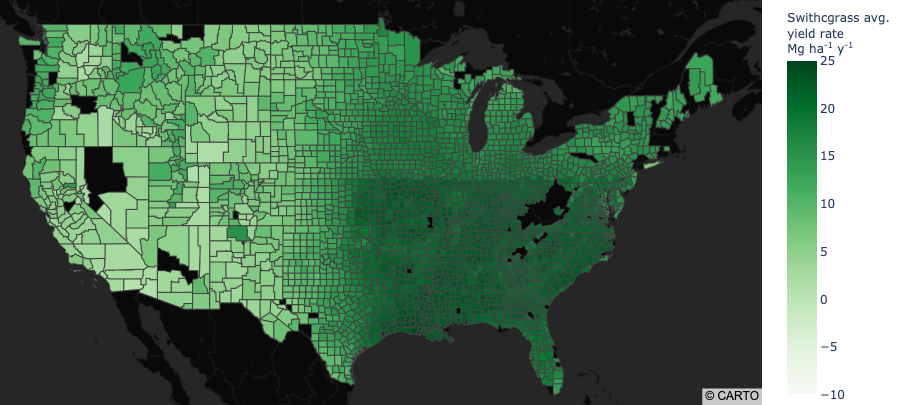

In [25]:
mapping(county_df[county_df.variety == 'base'],
        'yield_Mg_per_ha', 'Greens', 'Swithcgrass avg.<br>yield rate<br>Mg ha<sup>-1</sup> y<sup>-1</sup>',
        kwargs={"range_color": [-10, 25]})

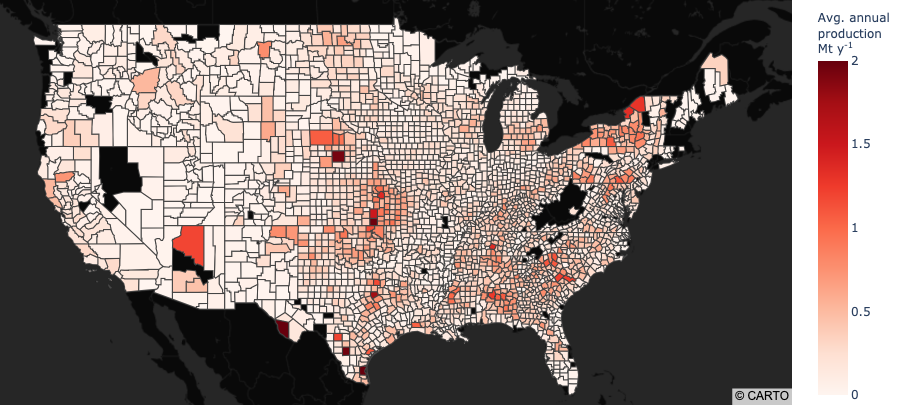

In [26]:
mapping(county_df[county_df.variety == 'base'],
        'prod_Mt', 'Reds', 'Avg. annual<br>production<br>Mt y<sup>-1</sup>',
        kwargs={"range_color": [0.0, 2.0]})

# Explore inter-annual yield variability

## Map precipitation gradients

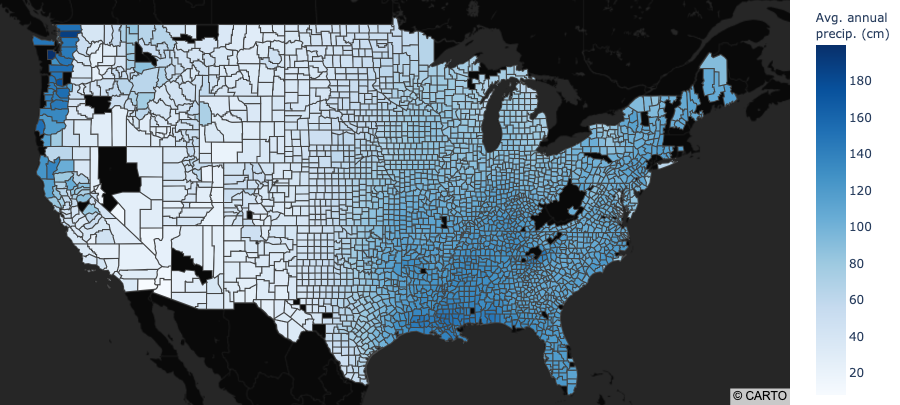

In [27]:
mapping(county_df[county_df.variety == 'base'],
        'annual_precip_cm', 'Blues', 'Avg. annual<br>precip. (cm)')

## Map yield STD & COV

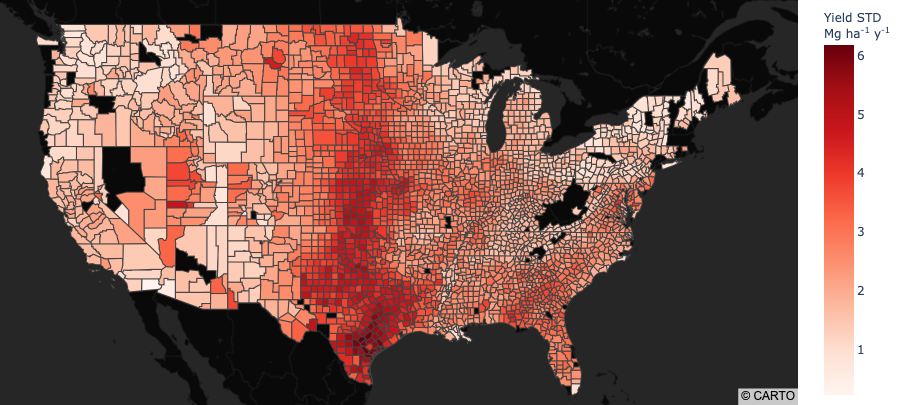

In [28]:
mapping(county_df[county_df.variety == 'base'],
        'yield_Mg_per_ha_std', 'Reds', 'Yield STD<br>Mg ha<sup>-1</sup> y<sup>-1</sup>')

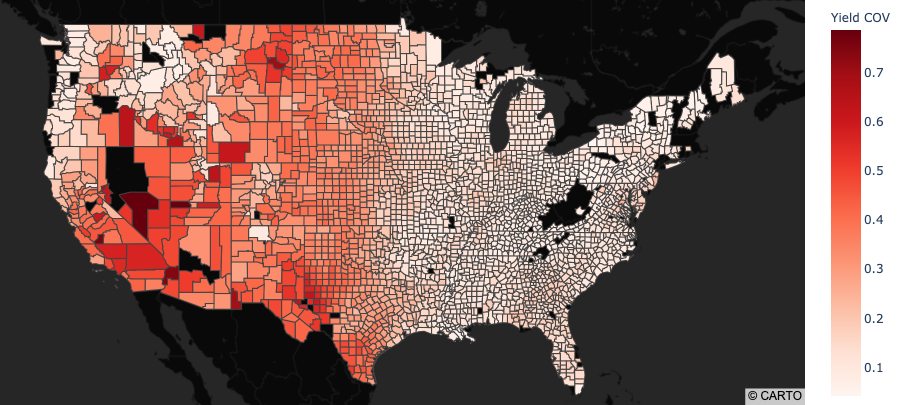

In [29]:
mapping(county_df[county_df.variety == 'base'],
        'yield_Mg_per_ha_cov', 'Reds', 'Yield COV')

# Yield comparisons

## CBI switchgrass vs. CABBI Miscanthus

In [30]:
# read list of all county FIPS codes (for exploring missing counties)
fips_df = pd.read_csv('01_raw_inputs/All_FIPS.csv')
fips_df['fips'] = fips_df['FIPS'].apply(lambda x: '{0:0>5}'.format(x))

# read in CABBI Miscanthus yield data
cabbi_file = "01_raw_inputs/miscanthus_county_averages_20211223.csv"
cabbi_df = pd.read_csv(cabbi_file)
cabbi_df['fips'] = cabbi_df['nearestfips'].apply(lambda x: '{0:0>5}'.format(x))
cabbi_df['CABBI_yield_Mg_per_ha'] = cabbi_df['crmvst'] * 0.01 * (1.0/0.45)
cabbi_df

nearestfips      crmvst        lat        long   fips  \
0            1001  632.324454  32.473627  -86.643715  01001   
1            1003  507.082259  30.526641  -87.669597  01003   
2            1005  619.502199  31.832132  -85.495884  01005   
3            1007  692.846465  33.002928  -87.135046  01007   
4            1009  739.274274  34.050116  -86.545193  01009   
...           ...         ...        ...         ...    ...   
2619        56033  397.252944  44.966671 -107.068836  56033   
2620        56035  278.677739  42.714495 -110.078551  56035   
2621        56037  126.148407  42.105203 -109.493924  56037   
2622        56043  283.786050  44.065463 -107.906396  56043   
2623        56045  464.511005  44.198669 -104.398670  56045   

      CABBI_yield_Mg_per_ha  
0                 14.051655  
1                 11.268495  
2                 13.766716  
3                 15.396588  
4                 16.428317  
...                     ...  
2619               8.827843  
2620               6.192839  
2621               2.803298  
2622               6.306357  
2623              10.322467  

[2624 rows x 6 columns]

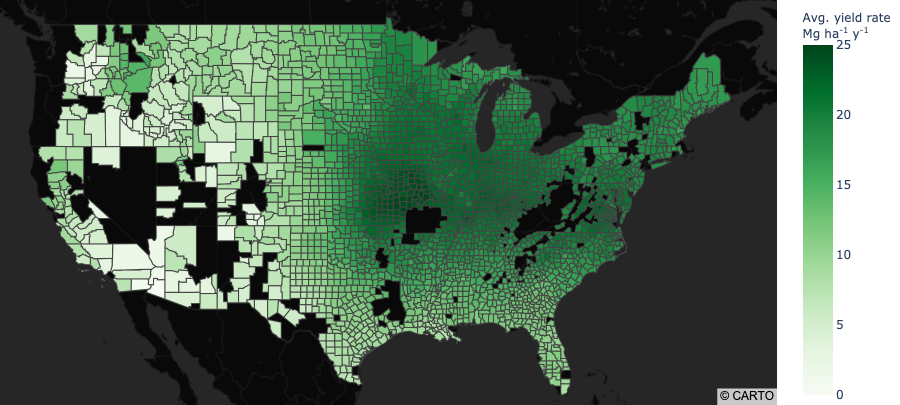

In [31]:
mapping(cabbi_df,
        'CABBI_yield_Mg_per_ha', 'Greens', 'Avg. yield rate<br>Mg ha<sup>-1</sup> y<sup>-1</sup>',
        kwargs={"range_color": [0, 25]})

In [32]:
comp_df = pd.merge(county_df, cabbi_df, on='fips', how='outer')
comp_df = pd.merge(fips_df, comp_df, on='fips', how='outer')
comp_df

FIPS    County    State   ST   fips variety        tot_ha   prod_Mt  \
0      1001.0   Autauga  Alabama   AL  01001    base  31214.547584  0.669676   
1      1003.0   Baldwin  Alabama   AL  01003    base  19794.098716  0.428314   
2      1005.0   Barbour  Alabama   AL  01005    base  34348.741190  0.756385   
3      1007.0      Bibb  Alabama   AL  01007    base   6070.472827  0.136300   
4      1009.0    Blount  Alabama   AL  01009    base  27967.981922  0.608412   
...       ...       ...      ...  ...    ...     ...           ...       ...   
3129  56039.0     Teton  Wyoming   WY  56039    base   7707.760967  0.076806   
3130  56041.0     Uinta  Wyoming   WY  56041    base   2241.368860  0.010734   
3131  56043.0  Washakie  Wyoming   WY  56043    base   3115.660099  0.020330   
3132  56045.0    Weston  Wyoming   WY  56045    base  49942.057254  0.305675   
3133      NaN       NaN      NaN  NaN  51595     NaN           NaN       NaN   

      yield_Mg_per_ha  initSOC_MgC_per_ha  ...  annual_precip_cm  \
0           21.453964           15.861822  ...        126.384666   
1           21.638478           14.308916  ...        142.606667   
2           22.020761           15.007400  ...        118.420994   
3           22.452943           18.788108  ...        131.636427   
4           21.753865           27.973606  ...        126.233706   
...               ...                 ...  ...               ...   
3129         9.964753           44.834972  ...         71.297985   
3130         4.788846           26.617103  ...         34.756267   
3131         6.525234           31.696533  ...         38.533469   
3132         6.120595           23.757367  ...         37.755811   
3133              NaN                 NaN  ...               NaN   

      leach_volit_frac  yield_Mg_per_ha_std  yield_Mg_per_ha_cov  \
0             0.704703             2.967179             0.138304   
1             0.791687             2.146405             0.099194   
2             0.667964             3.278115             0.148865   
3             0.645685             2.474065             0.110189   
4             0.601991             2.616056             0.120257   
...                ...                  ...                  ...   
3129          0.485087             0.924592             0.092786   
3130          0.444187             2.058416             0.429835   
3131          0.280592             2.237540             0.342906   
3132          0.190909             2.092920             0.341947   
3133               NaN                  NaN                  NaN   

      SOCgain_MgC_per_ha  nearestfips      crmvst        lat        long  \
0              17.486355       1001.0  632.324454  32.473627  -86.643715   
1              15.073730       1003.0  507.082259  30.526641  -87.669597   
2              17.442182       1005.0  619.502199  31.832132  -85.495884   
3              19.844120       1007.0  692.846465  33.002928  -87.135046   
4              21.665898       1009.0  739.274274  34.050116  -86.545193   
...                  ...          ...         ...        ...         ...   
3129           17.665414          NaN         NaN        NaN         NaN   
3130            8.874626          NaN         NaN        NaN         NaN   
3131            9.899356      56043.0  283.786050  44.065463 -107.906396   
3132           11.441051      56045.0  464.511005  44.198669 -104.398670   
3133                 NaN      51595.0  928.972380  36.717375  -77.437083   

      CABBI_yield_Mg_per_ha  
0                 14.051655  
1                 11.268495  
2                 13.766716  
3                 15.396588  
4                 16.428317  
...                     ...  
3129                    NaN  
3130                    NaN  
3131               6.306357  
3132              10.322467  
3133              20.643831  

[3134 rows x 28 columns]

In [33]:
# map yield comparison

comp_df['Misc-SWG_yield_per_ha'] = comp_df.CABBI_yield_Mg_per_ha - comp_df.yield_Mg_per_ha

mapping(comp_df,
        'Misc-SWG_yield_per_ha', 'BrBG', 'Miscanthus<br>yield advantage<br>Mg ha<sup>-1</sup> y<sup>-1</sup>',
        kwargs={"range_color": [-12, 12]})

## Comparison to PRISM-EM / BT23

In [34]:
# model yields in PRISM-ELM paper colors

# map continuous yields to discreet bins
def yield_rules(col):

    rules = {
        '0-1': (comp_df[col] < 1.0),
        '1-3': (comp_df[col] >= 1.0) & (comp_df[col] < 3.0),
        '3-6': (comp_df[col] >= 3.0) & (comp_df[col] < 6.0),
        '6-10': (comp_df[col] >= 6.0) & (comp_df[col] < 10.0),
        '10-14': (comp_df[col] >= 10.0) & (comp_df[col] < 14.0),
        '14-18': (comp_df[col] >= 14.0) & (comp_df[col] < 18.0),
        '18-22': (comp_df[col] >= 18.0) & (comp_df[col] < 22.0),
        '>22': (comp_df[col] >= 22.0)
    }
    return rules

comp_df['SWG_yield_bins'] = np.select(yield_rules('yield_Mg_per_ha').values(), yield_rules('yield_Mg_per_ha').keys(), default="")
comp_df['Misc_yield_bins'] = np.select(yield_rules('CABBI_yield_Mg_per_ha').values(), yield_rules('CABBI_yield_Mg_per_ha').keys(), default="")
comp_df

FIPS    County    State   ST   fips variety        tot_ha   prod_Mt  \
0      1001.0   Autauga  Alabama   AL  01001    base  31214.547584  0.669676   
1      1003.0   Baldwin  Alabama   AL  01003    base  19794.098716  0.428314   
2      1005.0   Barbour  Alabama   AL  01005    base  34348.741190  0.756385   
3      1007.0      Bibb  Alabama   AL  01007    base   6070.472827  0.136300   
4      1009.0    Blount  Alabama   AL  01009    base  27967.981922  0.608412   
...       ...       ...      ...  ...    ...     ...           ...       ...   
3129  56039.0     Teton  Wyoming   WY  56039    base   7707.760967  0.076806   
3130  56041.0     Uinta  Wyoming   WY  56041    base   2241.368860  0.010734   
3131  56043.0  Washakie  Wyoming   WY  56043    base   3115.660099  0.020330   
3132  56045.0    Weston  Wyoming   WY  56045    base  49942.057254  0.305675   
3133      NaN       NaN      NaN  NaN  51595     NaN           NaN       NaN   

      yield_Mg_per_ha  initSOC_MgC_per_ha  ...  yield_Mg_per_ha_cov  \
0           21.453964           15.861822  ...             0.138304   
1           21.638478           14.308916  ...             0.099194   
2           22.020761           15.007400  ...             0.148865   
3           22.452943           18.788108  ...             0.110189   
4           21.753865           27.973606  ...             0.120257   
...               ...                 ...  ...                  ...   
3129         9.964753           44.834972  ...             0.092786   
3130         4.788846           26.617103  ...             0.429835   
3131         6.525234           31.696533  ...             0.342906   
3132         6.120595           23.757367  ...             0.341947   
3133              NaN                 NaN  ...                  NaN   

      SOCgain_MgC_per_ha  nearestfips      crmvst        lat        long  \
0              17.486355       1001.0  632.324454  32.473627  -86.643715   
1              15.073730       1003.0  507.082259  30.526641  -87.669597   
2              17.442182       1005.0  619.502199  31.832132  -85.495884   
3              19.844120       1007.0  692.846465  33.002928  -87.135046   
4              21.665898       1009.0  739.274274  34.050116  -86.545193   
...                  ...          ...         ...        ...         ...   
3129           17.665414          NaN         NaN        NaN         NaN   
3130            8.874626          NaN         NaN        NaN         NaN   
3131            9.899356      56043.0  283.786050  44.065463 -107.906396   
3132           11.441051      56045.0  464.511005  44.198669 -104.398670   
3133                 NaN      51595.0  928.972380  36.717375  -77.437083   

      CABBI_yield_Mg_per_ha  Misc-SWG_yield_per_ha  SWG_yield_bins  \
0                 14.051655              -7.402310           18-22   
1                 11.268495             -10.369984           18-22   
2                 13.766716              -8.254046             >22   
3                 15.396588              -7.056355             >22   
4                 16.428317              -5.325547           18-22   
...                     ...                    ...             ...   
3129                    NaN                    NaN            6-10   
3130                    NaN                    NaN             3-6   
3131               6.306357              -0.218877            6-10   
3132              10.322467               4.201871            6-10   
3133              20.643831                    NaN                   

      Misc_yield_bins  
0               14-18  
1               10-14  
2               10-14  
3               14-18  
4               14-18  
...               ...  
3129                   
3130                   
3131             6-10  
3132            10-14  
3133            18-22  

[3134 rows x 31 columns]

In [35]:
prism_colors = {
    '0-1': 'rgb(135,110,64)',
    '1-3': 'rgb(204,168,100)',
    '3-6': 'rgb(243,217,164)',
    '6-10': 'rgb(254,255,214)',
    '10-14': 'rgb(169,232,145)',
    '14-18': 'rgb(108,194,111)',
    '18-22': 'rgb(70,153,71)',
    '>22': 'rgb(38,114,0)'
    }


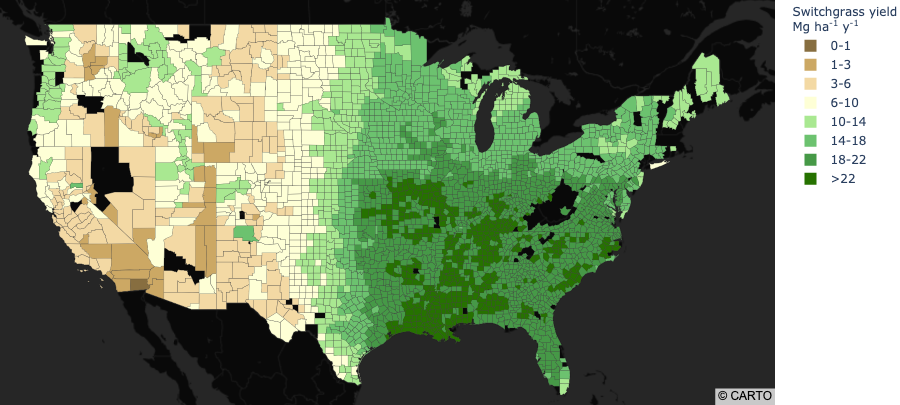

In [36]:
# map CBI switchgrass yield in the style of PRISM papers (for easy visual comparison)

interactive_map = False
my_map = px.choropleth_mapbox(comp_df[comp_df.SWG_yield_bins != ''], geojson=counties, locations='fips',
                              color='SWG_yield_bins',
                              color_discrete_map=prism_colors,
                              mapbox_style='carto-darkmatter',
                              zoom=map_zoom,
                              center={"lat": cen_lat, "lon": cen_lon},
                              labels={'SWG_yield_bins': 'Switchgrass yield<br>Mg ha<sup>-1</sup> y<sup>-1</sup>'},
                              category_orders={"SWG_yield_bins": ['0-1', '1-3', '3-6', '6-10', '10-14', '14-18', '18-22', '>22']})
my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                     margin={"r":0,"t":0,"l":0,"b":0})
my_map.update_traces(marker_line_width=0.2)

name = 'SWG_prism_yield'
if interactive_map:
    my_map.show()
else:
    my_map.write_image('03_figure_outputs/' + name+".png")
    display(Image(filename=('03_figure_outputs/' + name+".png")))
# my_map.write_image('03_figure_outputs/' + name+".pdf")

This yield map can be compared to the equivalents for lowland and upland switchgrass from Lee et al. 2018: 

![Lee et al. 2018 lowland switchgrass yield map](00_graphics/Lee2018-LowlandSwitchgrass.png)

*PRISM-EM estimate of lowland switchgrass yield potential, from Lee et al. 2018 Fig. 2.*

![Lee et al. 2018 upland switchgrass yield map](00_graphics/Lee2018-UplandSwitchgrass.png)

*PRISM-EM estimate of upland switchgrass yield potential, from Lee et al. 2018 Fig. 2.*

In [37]:
# map CABBI Miscanthus yield in the style of PRISM papers (for easy visual comparison)

interactive_map = False
my_map = px.choropleth_mapbox(comp_df[comp_df.Misc_yield_bins != ''], geojson=counties, locations='fips',
                              color='Misc_yield_bins',
                              color_discrete_map=prism_colors,
                              mapbox_style='carto-darkmatter',
                              zoom=map_zoom,
                              center={"lat": cen_lat, "lon": cen_lon},
                              labels={'Misc_yield_bins': 'Miscanthus yield<br>Mg ha<sup>-1</sup> y<sup>-1</sup>'},
                              category_orders={"Misc_yield_bins": ['0-1', '1-3', '3-6', '6-10', '10-14', '14-18', '18-22', '>22']})
my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                     margin={"r":0,"t":0,"l":0,"b":0})
my_map.update_traces(marker_line_width=0.2)

name = 'Misc_prism_yield'
if interactive_map:
    my_map.show()
else:
    my_map.write_image('03_figure_outputs/' + name+".png")
    display(Image(filename=('03_figure_outputs/' + name+".png")))
# my_map.write_image('03_figure_outputs/' + name+".pdf")

This CABBI Miscanthus yield map can be compared to the equivalent from Lee et al. 2018: 

![Lee et al. 2018 Miscanthus yield map](00_graphics/Lee2018-Miscanthus.png)

*PRISM-EM estimate of Miscanthus switchgrass yield potential, from Lee et al. 2018 Fig. 4.*

# Land use and modeling extent

## Cropland & abandoned land

Comparing the amount of abandoned land as per Zumkehr & Campbell 2013, versus active annual cropland area (i.e., “harvested”, “failed”, and “summer fallow” as per the 2017 Census of Agriculture, but excluding idle cropland and cropland–pasture, following Lark et al., 2020)

In [38]:
peak_df = run_df[['fips', 'peak_year']].groupby('fips').mean()
peak_df.reset_index(inplace=True)
peak_df['fips'] = peak_df['fips'].apply(lambda x: '{0:0>5}'.format(x))
peak_df

fips    peak_year
0     01001  1950.000000
1     01003  1969.965398
2     01005  1950.000000
3     01007  1950.000000
4     01009  1950.000000
...     ...          ...
2882  56037  1997.222222
2883  56039  1970.630631
2884  56041  1992.058824
2885  56043  1995.166667
2886  56045  1999.905437

[2887 rows x 2 columns]

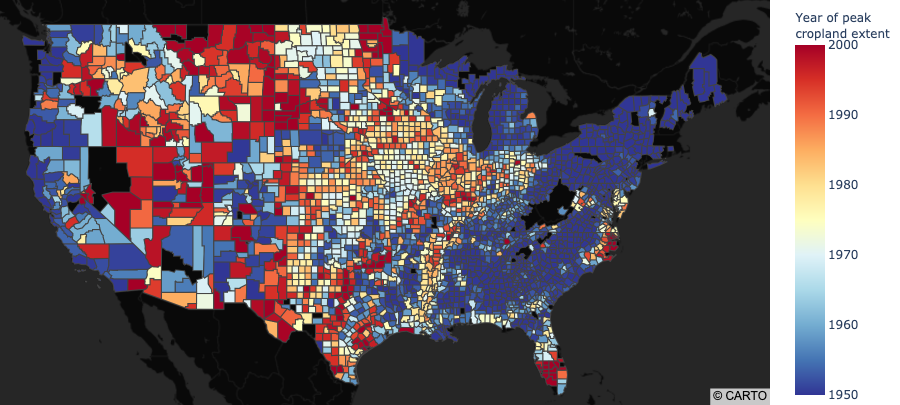

In [39]:
mapping(peak_df, 'peak_year', 'RdYlBu_r', 'Year of peak<br>cropland extent')
# mapping(peak_df, 'peak_year', 'RdYlBu_r', 'Year of peak<br>cropland extent', kwargs={"range_color": [1850, 2000]})

This map can be verified against the equivalent from Zumkehr & Campbell 2013, based on which our simulations were originally specified: 

![Zumkehr & Campbell 2013 year of peak cropland extent](00_graphics/ZC2013-PeakYear.png)

*Year of peak extent of annual cropland, from Zumkehr & Campbell 2013 Fig. 3. Note that we have truncated the DayCent simulation specification such that any land abandoned prior to 1950 is simulated as having been abandoned in 1950, to align with standard model spin-up workflows.*

In [40]:
coa_df = pd.read_csv('/Users/53f/ORNL_OneDrive/Notebooks/SPARC/NARR-CoA_comparison/coa_ha.csv')
coa_df['fips'] = coa_df['fips'].apply(lambda x: '{0:0>5}'.format(x))
coa_df

fips    county_ha   CoA_harv_ha  CoA_fail_ha  CoA_fallow_ha  \
0     01001   153958.924  11151.932102   400.639140     270.330248   
1     01003   411754.056  38162.294486  1587.987864     225.814788   
2     01005   229182.884  10210.632466   211.246092     578.700980   
3     01007   161248.738   4375.465032          NaN            NaN   
4     01009   166996.984  12582.092426   134.760438     669.350644   
...     ...          ...           ...          ...            ...   
3096  56037  2700502.091  11476.085588   177.252468     790.351758   
3097  56039  1034803.161   5177.957370          NaN            NaN   
3098  56041   539047.376  19408.740560          NaN            NaN   
3099  56043   579784.191  13484.137520   503.024698    1017.785290   
3100  56045   621105.051   8733.528566  2435.400348    1998.339468   

      CoA_harv_0_ha  CoA_fail_0_ha  CoA_fallow_0_ha  CoA_tot_0_ha  \
0      11151.932102     400.639140       270.330248  11822.901490   
1      38162.294486    1587.987864       225.814788  39976.097138   
2      10210.632466     211.246092       578.700980  11000.579538   
3       4375.465032       0.000000         0.000000   4375.465032   
4      12582.092426     134.760438       669.350644  13386.203508   
...             ...            ...              ...           ...   
3096   11476.085588     177.252468       790.351758  12443.689814   
3097    5177.957370       0.000000         0.000000   5177.957370   
3098   19408.740560       0.000000         0.000000  19408.740560   
3099   13484.137520     503.024698      1017.785290  15004.947508   
3100    8733.528566    2435.400348      1998.339468  13167.268382   

      CoA_tot_pct  CoA_harv_pct  CoA_fail_pct  CoA_fallow_pct  
0        7.679257      7.243446      0.260225        0.175586  
1        9.708732      9.268226      0.385664        0.054842  
2        4.799913      4.455233      0.092174        0.252506  
3        2.713488      2.713488      0.000000        0.000000  
4        8.015835      7.534323      0.080696        0.400816  
...           ...           ...           ...             ...  
3096     0.460792      0.424961      0.006564        0.029267  
3097     0.500381      0.500381      0.000000        0.000000  
3098     3.600563      3.600563      0.000000        0.000000  
3099     2.588023      2.325717      0.086761        0.175546  
3100     2.119974      1.406127      0.392108        0.321739  

[3101 rows x 13 columns]

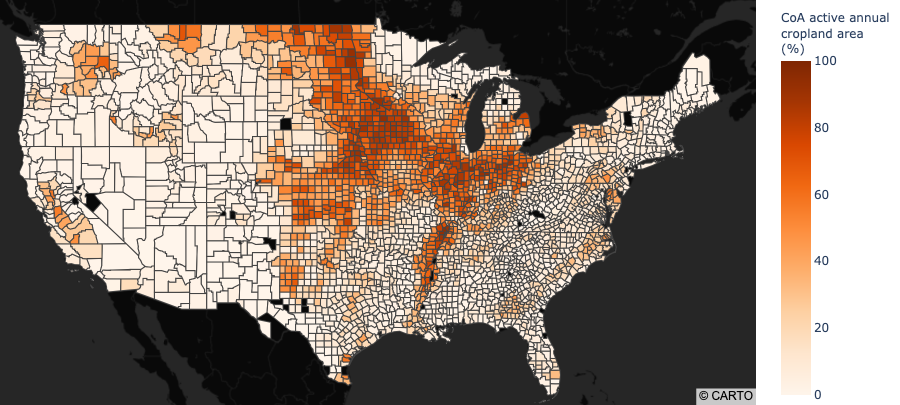

In [41]:
mapping(coa_df,
        'CoA_tot_pct', 'Oranges', 'CoA active annual<br>cropland area<br>(%)',
       kwargs={"range_color": [0, 100]})

In [42]:
comp_df = pd.merge(comp_df, coa_df, on='fips', how='outer')
comp_df['abandoned_pct'] = (comp_df.tot_ha / comp_df.county_ha) * 100.0
comp_df['abandoned_to_active_cropland'] = comp_df.tot_ha / comp_df.CoA_tot_0_ha
comp_df

FIPS    County    State   ST   fips variety        tot_ha   prod_Mt  \
0      1001.0   Autauga  Alabama   AL  01001    base  31214.547584  0.669676   
1      1003.0   Baldwin  Alabama   AL  01003    base  19794.098716  0.428314   
2      1005.0   Barbour  Alabama   AL  01005    base  34348.741190  0.756385   
3      1007.0      Bibb  Alabama   AL  01007    base   6070.472827  0.136300   
4      1009.0    Blount  Alabama   AL  01009    base  27967.981922  0.608412   
...       ...       ...      ...  ...    ...     ...           ...       ...   
3129  56039.0     Teton  Wyoming   WY  56039    base   7707.760967  0.076806   
3130  56041.0     Uinta  Wyoming   WY  56041    base   2241.368860  0.010734   
3131  56043.0  Washakie  Wyoming   WY  56043    base   3115.660099  0.020330   
3132  56045.0    Weston  Wyoming   WY  56045    base  49942.057254  0.305675   
3133      NaN       NaN      NaN  NaN  51595     NaN           NaN       NaN   

      yield_Mg_per_ha  initSOC_MgC_per_ha  ...  CoA_harv_0_ha  CoA_fail_0_ha  \
0           21.453964           15.861822  ...   11151.932102     400.639140   
1           21.638478           14.308916  ...   38162.294486    1587.987864   
2           22.020761           15.007400  ...   10210.632466     211.246092   
3           22.452943           18.788108  ...    4375.465032       0.000000   
4           21.753865           27.973606  ...   12582.092426     134.760438   
...               ...                 ...  ...            ...            ...   
3129         9.964753           44.834972  ...    5177.957370       0.000000   
3130         4.788846           26.617103  ...   19408.740560       0.000000   
3131         6.525234           31.696533  ...   13484.137520     503.024698   
3132         6.120595           23.757367  ...    8733.528566    2435.400348   
3133              NaN                 NaN  ...            NaN            NaN   

      CoA_fallow_0_ha  CoA_tot_0_ha  CoA_tot_pct  CoA_harv_pct  CoA_fail_pct  \
0          270.330248  11822.901490     7.679257      7.243446      0.260225   
1          225.814788  39976.097138     9.708732      9.268226      0.385664   
2          578.700980  11000.579538     4.799913      4.455233      0.092174   
3            0.000000   4375.465032     2.713488      2.713488      0.000000   
4          669.350644  13386.203508     8.015835      7.534323      0.080696   
...               ...           ...          ...           ...           ...   
3129         0.000000   5177.957370     0.500381      0.500381      0.000000   
3130         0.000000  19408.740560     3.600563      3.600563      0.000000   
3131      1017.785290  15004.947508     2.588023      2.325717      0.086761   
3132      1998.339468  13167.268382     2.119974      1.406127      0.392108   
3133              NaN           NaN          NaN           NaN           NaN   

      CoA_fallow_pct  abandoned_pct  abandoned_to_active_cropland  
0           0.175586      20.274595                      2.640177  
1           0.054842       4.807263                      0.495148  
2           0.252506      14.987481                      3.122448  
3           0.000000       3.764664                      1.387389  
4           0.400816      16.747597                      2.089314  
...              ...            ...                           ...  
3129        0.000000       0.744853                      1.488572  
3130        0.000000       0.415802                      0.115482  
3131        0.175546       0.537383                      0.207642  
3132        0.321739       8.040839                      3.792894  
3133             NaN            NaN                           NaN  

[3134 rows x 45 columns]

In [43]:
mapping(comp_df,
        'abandoned_pct', 'Oranges', 'Abandoned<br>cropland area<br>(%)',
       kwargs={"range_color": [0, 30]})

This map can be verified against the equivalent from Zumkehr & Campbell 2013, based on which our simulations were originally specified: 

![Zumkehr & Campbell 2013 year of peak cropland extent](00_graphics/ZC2013-CorrectedAbandonedLand.png)

*Abandoned cropland extent after subtracting land that may have been reforested or urbanized, from Zumkehr & Campbell 2013 Fig. 3. This is their estimate of abandoned cropland potentially available for bioenergy production. Note that this original analysis is visualized on a 4 km grid, whereas the prior figure shows county average values from the DayCent workflow (and thus the peak values are lower).*

In [44]:
mapping(comp_df,
        'abandoned_to_active_cropland', 'RdBu_r', 'Abandoned:active<br>cropland',
       kwargs={"range_color": [0, 2]})

## Missing counties

Explore whether gaps in CBI switchgrass & CABBI Miscanthus results datasets are counties with significant amounts of active annual cropland or abandoned land. 

In [45]:
missing_df = fips_df.merge(county_df.drop_duplicates(), on='fips', how='left', indicator=True)

mapping(missing_df[missing_df._merge == 'left_only'],
        'FIPS', 'Viridis', '', kwargs={"range_color": [0, 1000]})

In [46]:
# map out gaps in the maps

rules = {
    'Both': (~comp_df.yield_Mg_per_ha.isna()) & (~comp_df.CABBI_yield_Mg_per_ha.isna()),
    'No switchgrass': (comp_df.yield_Mg_per_ha.isna()) & (~comp_df.CABBI_yield_Mg_per_ha.isna()),
    'No miscanthus': (~comp_df.yield_Mg_per_ha.isna()) & (comp_df.CABBI_yield_Mg_per_ha.isna()),
    'Neither': (comp_df.yield_Mg_per_ha.isna()) & (comp_df.CABBI_yield_Mg_per_ha.isna())
}

comp_df['missing'] = np.select(rules.values(), rules.keys(), default="")
comp_df

FIPS    County    State   ST   fips variety        tot_ha   prod_Mt  \
0      1001.0   Autauga  Alabama   AL  01001    base  31214.547584  0.669676   
1      1003.0   Baldwin  Alabama   AL  01003    base  19794.098716  0.428314   
2      1005.0   Barbour  Alabama   AL  01005    base  34348.741190  0.756385   
3      1007.0      Bibb  Alabama   AL  01007    base   6070.472827  0.136300   
4      1009.0    Blount  Alabama   AL  01009    base  27967.981922  0.608412   
...       ...       ...      ...  ...    ...     ...           ...       ...   
3129  56039.0     Teton  Wyoming   WY  56039    base   7707.760967  0.076806   
3130  56041.0     Uinta  Wyoming   WY  56041    base   2241.368860  0.010734   
3131  56043.0  Washakie  Wyoming   WY  56043    base   3115.660099  0.020330   
3132  56045.0    Weston  Wyoming   WY  56045    base  49942.057254  0.305675   
3133      NaN       NaN      NaN  NaN  51595     NaN           NaN       NaN   

      yield_Mg_per_ha  initSOC_MgC_per_ha  ...  CoA_fail_0_ha  \
0           21.453964           15.861822  ...     400.639140   
1           21.638478           14.308916  ...    1587.987864   
2           22.020761           15.007400  ...     211.246092   
3           22.452943           18.788108  ...       0.000000   
4           21.753865           27.973606  ...     134.760438   
...               ...                 ...  ...            ...   
3129         9.964753           44.834972  ...       0.000000   
3130         4.788846           26.617103  ...       0.000000   
3131         6.525234           31.696533  ...     503.024698   
3132         6.120595           23.757367  ...    2435.400348   
3133              NaN                 NaN  ...            NaN   

      CoA_fallow_0_ha  CoA_tot_0_ha  CoA_tot_pct  CoA_harv_pct  CoA_fail_pct  \
0          270.330248  11822.901490     7.679257      7.243446      0.260225   
1          225.814788  39976.097138     9.708732      9.268226      0.385664   
2          578.700980  11000.579538     4.799913      4.455233      0.092174   
3            0.000000   4375.465032     2.713488      2.713488      0.000000   
4          669.350644  13386.203508     8.015835      7.534323      0.080696   
...               ...           ...          ...           ...           ...   
3129         0.000000   5177.957370     0.500381      0.500381      0.000000   
3130         0.000000  19408.740560     3.600563      3.600563      0.000000   
3131      1017.785290  15004.947508     2.588023      2.325717      0.086761   
3132      1998.339468  13167.268382     2.119974      1.406127      0.392108   
3133              NaN           NaN          NaN           NaN           NaN   

      CoA_fallow_pct  abandoned_pct  abandoned_to_active_cropland  \
0           0.175586      20.274595                      2.640177   
1           0.054842       4.807263                      0.495148   
2           0.252506      14.987481                      3.122448   
3           0.000000       3.764664                      1.387389   
4           0.400816      16.747597                      2.089314   
...              ...            ...                           ...   
3129        0.000000       0.744853                      1.488572   
3130        0.000000       0.415802                      0.115482   
3131        0.175546       0.537383                      0.207642   
3132        0.321739       8.040839                      3.792894   
3133             NaN            NaN                           NaN   

             missing  
0               Both  
1               Both  
2               Both  
3               Both  
4               Both  
...              ...  
3129   No miscanthus  
3130   No miscanthus  
3131            Both  
3132            Both  
3133  No switchgrass  

[3134 rows x 46 columns]

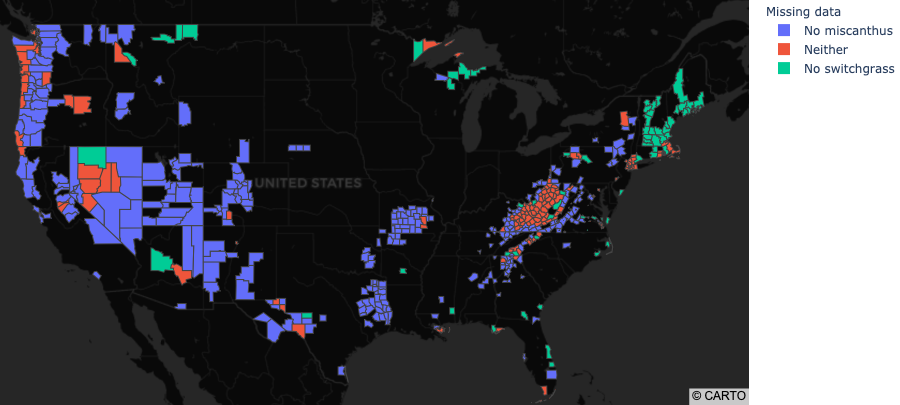

In [47]:
missing_df = comp_df[comp_df.missing != "Both"].copy()

my_map = px.choropleth_mapbox(missing_df, geojson=counties, locations='fips',
                              color='missing',
                              mapbox_style='carto-darkmatter',
                              zoom=map_zoom,
                              center={"lat": cen_lat, "lon": cen_lon},
                              labels={'missing': 'Missing data'})
my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                     margin={"r":0,"t":0,"l":0,"b":0})
if interactive_map:
    my_map.show()
else:
    my_map.write_image("03_figure_outputs/Missing.png")
    display(Image(filename="03_figure_outputs/Missing.png"))
# my_map.write_image("03_figure_outputs/Missing.pdf")

In [48]:
# convert 'missing' column to binary indicators for miscanthus and switchgrass data separately
rules = {
    'Data': comp_df.missing.isin(['Both', 'No switchgrass']),
    'No data': comp_df.missing.isin(['No miscanthus', "Neither"])
}
comp_df['Misc_data'] = np.select(rules.values(), rules.keys())

rules = {
    'Data': comp_df.missing.isin(['Both', 'No miscanthus']),
    'No data': comp_df.missing.isin(['No switchgrass', "Neither"])
}
comp_df['SWG_data'] = np.select(rules.values(), rules.keys())

comp_df

FIPS    County    State   ST   fips variety        tot_ha   prod_Mt  \
0      1001.0   Autauga  Alabama   AL  01001    base  31214.547584  0.669676   
1      1003.0   Baldwin  Alabama   AL  01003    base  19794.098716  0.428314   
2      1005.0   Barbour  Alabama   AL  01005    base  34348.741190  0.756385   
3      1007.0      Bibb  Alabama   AL  01007    base   6070.472827  0.136300   
4      1009.0    Blount  Alabama   AL  01009    base  27967.981922  0.608412   
...       ...       ...      ...  ...    ...     ...           ...       ...   
3129  56039.0     Teton  Wyoming   WY  56039    base   7707.760967  0.076806   
3130  56041.0     Uinta  Wyoming   WY  56041    base   2241.368860  0.010734   
3131  56043.0  Washakie  Wyoming   WY  56043    base   3115.660099  0.020330   
3132  56045.0    Weston  Wyoming   WY  56045    base  49942.057254  0.305675   
3133      NaN       NaN      NaN  NaN  51595     NaN           NaN       NaN   

      yield_Mg_per_ha  initSOC_MgC_per_ha  ...  CoA_tot_0_ha  CoA_tot_pct  \
0           21.453964           15.861822  ...  11822.901490     7.679257   
1           21.638478           14.308916  ...  39976.097138     9.708732   
2           22.020761           15.007400  ...  11000.579538     4.799913   
3           22.452943           18.788108  ...   4375.465032     2.713488   
4           21.753865           27.973606  ...  13386.203508     8.015835   
...               ...                 ...  ...           ...          ...   
3129         9.964753           44.834972  ...   5177.957370     0.500381   
3130         4.788846           26.617103  ...  19408.740560     3.600563   
3131         6.525234           31.696533  ...  15004.947508     2.588023   
3132         6.120595           23.757367  ...  13167.268382     2.119974   
3133              NaN                 NaN  ...           NaN          NaN   

      CoA_harv_pct  CoA_fail_pct  CoA_fallow_pct  abandoned_pct  \
0         7.243446      0.260225        0.175586      20.274595   
1         9.268226      0.385664        0.054842       4.807263   
2         4.455233      0.092174        0.252506      14.987481   
3         2.713488      0.000000        0.000000       3.764664   
4         7.534323      0.080696        0.400816      16.747597   
...            ...           ...             ...            ...   
3129      0.500381      0.000000        0.000000       0.744853   
3130      3.600563      0.000000        0.000000       0.415802   
3131      2.325717      0.086761        0.175546       0.537383   
3132      1.406127      0.392108        0.321739       8.040839   
3133           NaN           NaN             NaN            NaN   

      abandoned_to_active_cropland         missing  Misc_data  SWG_data  
0                         2.640177            Both       Data      Data  
1                         0.495148            Both       Data      Data  
2                         3.122448            Both       Data      Data  
3                         1.387389            Both       Data      Data  
4                         2.089314            Both       Data      Data  
...                            ...             ...        ...       ...  
3129                      1.488572   No miscanthus    No data      Data  
3130                      0.115482   No miscanthus    No data      Data  
3131                      0.207642            Both       Data      Data  
3132                      3.792894            Both       Data      Data  
3133                           NaN  No switchgrass       Data   No data  

[3134 rows x 48 columns]

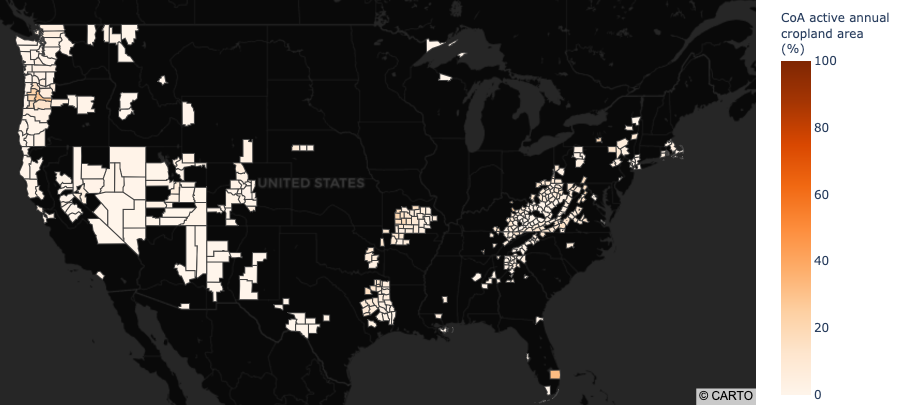

In [49]:
mapping(comp_df[comp_df.missing.isin(['No miscanthus', 'Neither'])],
        'CoA_tot_pct', 'Oranges', 'CoA active annual<br>cropland area<br>(%)', descrip='_Misc_missing',
       kwargs={"range_color": [0, 100]})

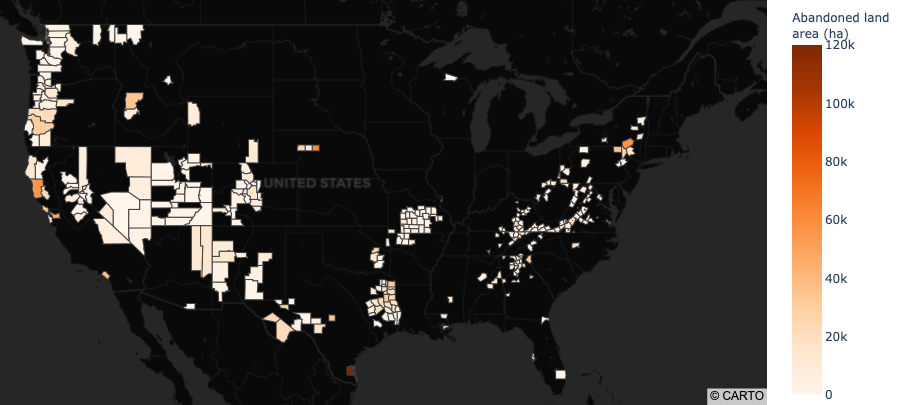

In [50]:
mapping(comp_df[comp_df.missing.isin(['No miscanthus', 'Neither'])],
        'tot_ha', 'Oranges', 'Abandoned land<br>area (ha)', descrip='_Misc_missing',
       kwargs={"range_color": [0, 120e3]})

In [51]:
mapping(comp_df[comp_df.missing.isin(['No switchgrass', 'Neither'])],
        'CoA_tot_pct', 'Oranges', 'CoA active annual<br>cropland area<br>(%)', descrip='_SWG_missing',
       kwargs={"range_color": [0, 100]})

# Exploring yield sensitivity to precipitation

## Map yield-precip correlation

In [52]:
# create list to store regression results
reg_results = []

# create dataframe to store full annual_df plus a normalized column
norm_cols = [x for x in annual_df.columns]
norm_df = pd.DataFrame(columns=norm_cols)

# subset the annual data from each county, one at a time
counties = annual_df['fips'].unique()
for county in counties:
    my_county = annual_df[annual_df['fips'] == county].copy()
    
    # regress annual yield vs. annual precipitation w/in the county
    X = my_county.annual_precip_cm
    Y = my_county.yield_Mg_per_ha
    X2 = sm.add_constant(X)
    est = sm.OLS(Y, X2)
    est2 = est.fit()
    r2 = est2.rsquared_adj
    
    reg_results.append([county, r2])
    
    # normalize annual results against best-yielding year
    best_yield = my_county.yield_Mg_per_ha.max()
    my_county['norm_yield'] = my_county.yield_Mg_per_ha / best_yield
    
    norm_df = pd.concat([norm_df, my_county], axis=0)

norm_df.to_csv('02_intermediate_outputs/' + base_sims+'-annual_norm.csv', index=False)
    
# convert regression results array to DataFrame
reg_df = pd.DataFrame(reg_results, columns =['fips', 'r2'])
reg_df.to_csv('02_intermediate_outputs/' + base_sims+'-yield_precip_r2s.csv', index=False)
reg_df

fips        r2
0     01001  0.478936
1     01003  0.181223
2     01005  0.502560
3     01007  0.251234
4     01009  0.128837
...     ...       ...
2882  56037  0.543413
2883  56039  0.107651
2884  56041  0.414676
2885  56043  0.612237
2886  56045  0.533676

[2887 rows x 2 columns]

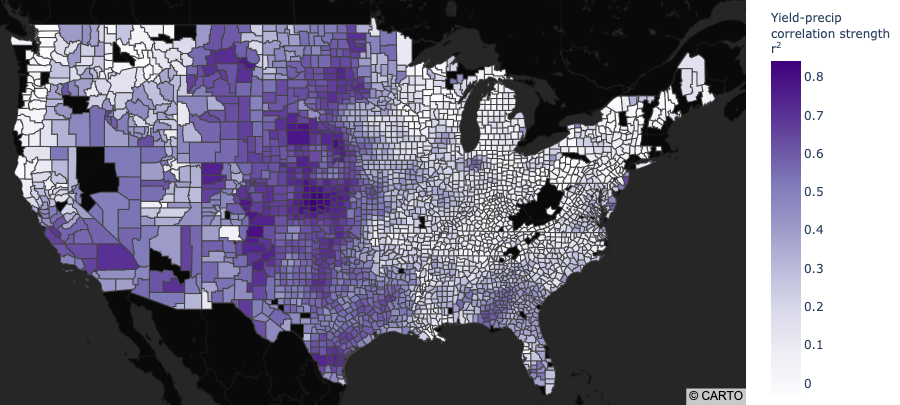

In [78]:
mapping(reg_df,
        'r2', 'Purples', 'Yield-precip<br>correlation strength<br>r<sup>2</sup>')

## Yield-precip sensitivity by Farm Resource Region

We can discretize our yield-vs-precipitation analysis by Farm Resource Region, using the FIPS lookup table archived at https://wayback.archive-it.org/5923/20110913212900/http:/www.ers.usda.gov/Briefing/ARMS/resourceregions/resourceregions.htm

In [54]:
frr_df = pd.read_excel("01_raw_inputs/FRR_data.xls", sheet_name='data')
lookup_df = pd.read_excel("01_raw_inputs/FRR_data.xls", sheet_name='lookup')
frr_df = pd.merge(lookup_df, frr_df, on='FRR', validate="1:m")
frr_df['fips'] = frr_df['fips'].apply(lambda x: '{0:0>5}'.format(x))
frr_df

FRR         Region_name   fips
0       1           Heartland  17011
1       1           Heartland  17015
2       1           Heartland  17073
3       1           Heartland  17085
4       1           Heartland  17103
...   ...                 ...    ...
3107    9  Mississippi Portal  47125
3108    9  Mississippi Portal  47135
3109    9  Mississippi Portal  47147
3110    9  Mississippi Portal  47161
3111    9  Mississippi Portal  47181

[3112 rows x 3 columns]

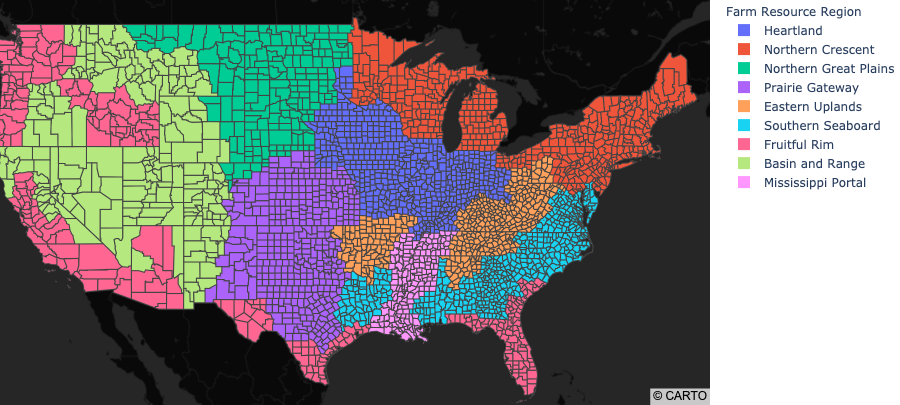

In [79]:
interactive_map = False
my_map = px.choropleth_mapbox(frr_df, geojson=counties, locations='fips',
                              color='Region_name',
                              mapbox_style='carto-darkmatter',
                              zoom=map_zoom,
                              center={"lat": cen_lat, "lon": cen_lon},
                              labels={'Region_name': 'Farm Resource Region'})
my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                     margin={"r":0,"t":0,"l":0,"b":0})
if interactive_map:
    my_map.show()
else:
    my_map.write_image("03_figure_outputs/FRR.png")
    display(Image(filename="03_figure_outputs/FRR.png"))
# my_map.write_image("03_figure_outputs/FRR.pdf")

In [56]:
# merge FRR data into normalized annual dataframe

norm_df = pd.merge(norm_df, frr_df, on='fips')
norm_df

fips variety  time        tot_ha   prod_Mt  yield_Mg_per_ha  \
0       01001    base  2022  31214.547584  0.510333        16.349190   
1       01001    base  2023  31214.547584  0.586823        18.799675   
2       01001    base  2024  31214.547584  0.739997        23.706802   
3       01001    base  2025  31214.547584  0.724218        23.201291   
4       01001    base  2026  31214.547584  0.728972        23.353610   
...       ...     ...   ...           ...       ...              ...   
101005  56045    base  2052  49942.057254  0.404776         8.104920   
101006  56045    base  2053  49942.057254  0.301059         6.028175   
101007  56045    base  2054  49942.057254  0.170945         3.422875   
101008  56045    base  2055  49942.057254  0.276574         5.537889   
101009  56045    base  2056  49942.057254  0.351972         7.047606   

        initSOC_MgC_per_ha  SOC_MgC_per_ha  dSOC_MgC_per_ha  dN2ON_kgN_per_ha  \
0                15.861822       36.548395        -0.466800          0.938132   
1                15.861822       36.412973        -0.135422          1.074047   
2                15.861822       36.108252        -0.304721          1.348264   
3                15.861822       35.805112        -0.303140          1.413249   
4                15.861822       35.562531        -0.242581          1.469613   
...                    ...             ...              ...               ...   
101005           23.757367       36.794599         0.166503          0.807732   
101006           23.757367       36.998930         0.204331          0.824704   
101007           23.757367       37.120274         0.121344          0.680734   
101008           23.757367       37.211988         0.091714          1.468600   
101009           23.757367       37.236173         0.024185          1.800729   

        iN2ON_kgN_per_ha  kgCH4_ox_per_ha  ghg_MgCO2e_per_ha  \
0               0.387267         1.749208           2.213224   
1               0.392042         1.948676           1.052026   
2               0.548503         1.659025           1.859768   
3               0.551111         1.570409           1.884601   
4               0.380166         1.674398           1.612090   
...                  ...              ...                ...   
101005          0.062300         2.664367          -0.322445   
101006          0.266043         2.685649          -0.369755   
101007          0.038478         2.872895          -0.225613   
101008          0.732901         2.402034           0.513279   
101009          0.126804         2.420447           0.646127   

        volit_kgN_per_ha  leached_kgN_per_ha  annual_precip_cm  \
0               7.135401           40.196248        127.492916   
1              10.317146           36.697783        118.404408   
2              12.711367           54.108848        142.141696   
3              12.486592           54.626172        173.520361   
4              12.599415           31.883211        121.974052   
...                  ...                 ...               ...   
101005          4.805261            0.466223         36.799547   
101006          3.790933           28.716341         33.363050   
101007          2.426031            0.000371         20.742364   
101008          3.445930           90.820559         51.009101   
101009          4.249247            8.897039         32.953848   

        leach_volit_frac  norm_yield  FRR            Region_name  
0               0.631089    0.655279    6      Southern Seaboard  
1               0.626866    0.753495    6      Southern Seaboard  
2               0.890936    0.950174    6      Southern Seaboard  
3               0.894837    0.929913    6      Southern Seaboard  
4               0.593102    0.936018    6      Southern Seaboard  
...                  ...         ...  ...                    ...  
101005          0.070286    0.809152    3  Northern Great Plains  
101006          0.433430    0.601821    3  Northern Great Plains  
101007

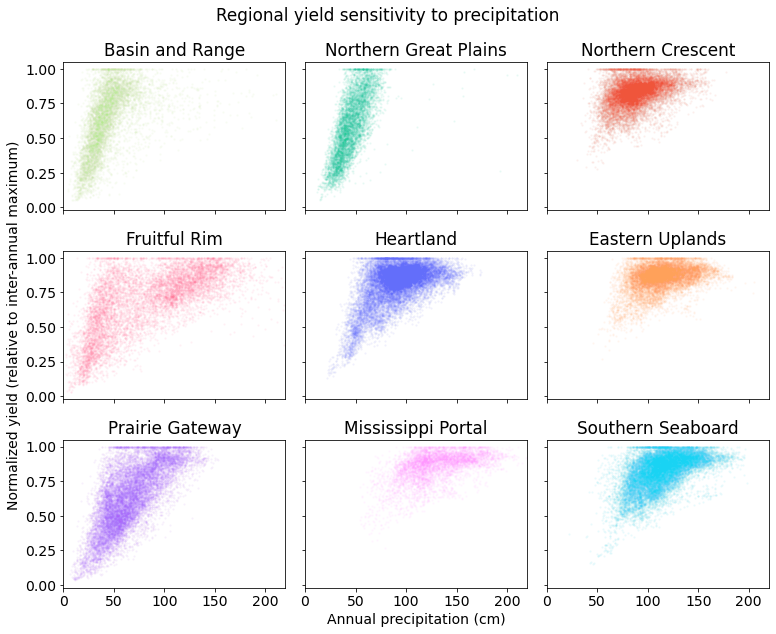

In [57]:
frr_panels = [
[['Basin and Range', '#B6E880'], ['Northern Great Plains', '#00CC96'], ['Northern Crescent', '#EF553B']],
[['Fruitful Rim', '#FF6692'], ['Heartland', '#636EFA'], ['Eastern Uplands', '#FFA15A']],
[['Prairie Gateway', '#AB63FA'], ['Mississippi Portal', '#FF97FF'], ['Southern Seaboard', '#19D3F3']]
]

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(11, 9), nrows=len(frr_panels), ncols=len(frr_panels[1]), sharex=True, sharey=True)
fig.suptitle('Regional yield sensitivity to precipitation')
ax[2, 1].set_xlabel("Annual precipitation (cm)")
ax[1, 0].set_ylabel("Normalized yield (relative to inter-annual maximum)")
ax[0, 0].set_xlim([0, 220])

# iterate through panel structure
for i in range(len(frr_panels)):
    for j in range(len(frr_panels[i])):
        region, color = frr_panels[i][j]
        ax[i, j].set_title(region)
        data = norm_df[norm_df.Region_name == region]
        
        # plot normalized yield response to precipitation
        ax[i, j].scatter(data.annual_precip_cm, data.norm_yield, color=color, alpha=0.05, s=2)

plt.tight_layout()
# plt.savefig('Norm_yield-vs-precip-by-FRR.pdf')
plt.savefig('03_figure_outputs/Norm_yield-vs-precip-by-FRR.png')

# Soil C change

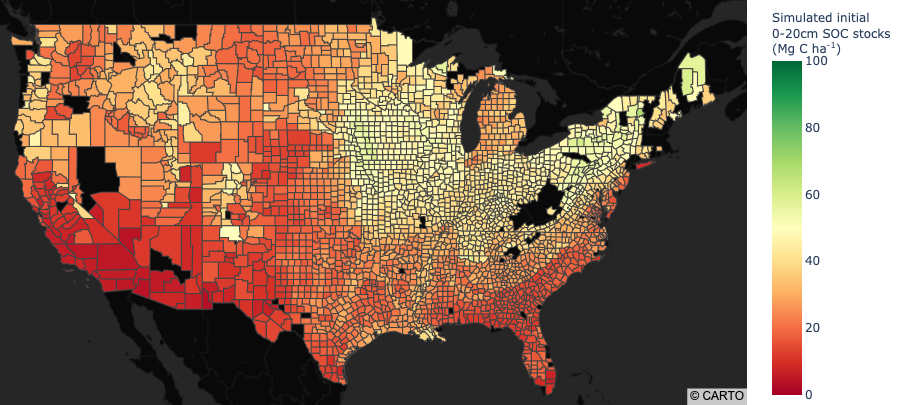

In [80]:
# map change in SOC since beginning of simulation
county_df['SOCgain_MgC_per_ha'] = county_df['SOC_MgC_per_ha'] - county_df['initSOC_MgC_per_ha']

mapping(county_df, 'initSOC_MgC_per_ha', 'RdYlGn', 'Simulated initial<br>0-20cm SOC stocks<br>(Mg C ha<sup>-1</sup>)',
    kwargs={"range_color": [0, 100]})

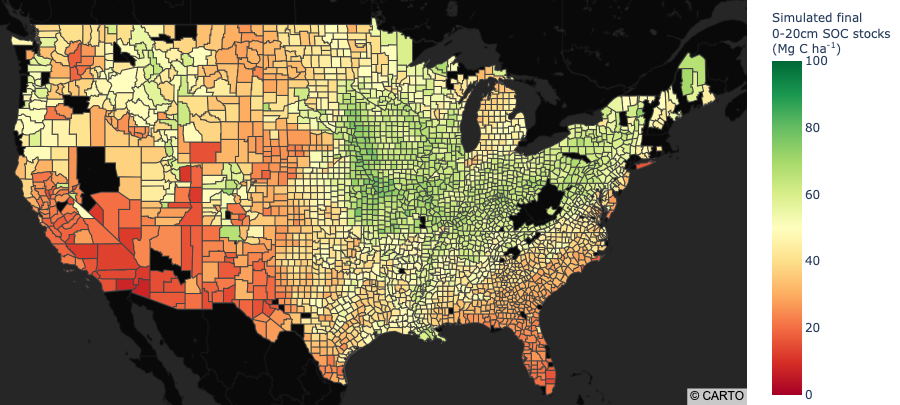

In [81]:
mapping(county_df, 'SOC_MgC_per_ha', 'RdYlGn', 'Simulated final<br>0-20cm SOC stocks<br>(Mg C ha<sup>-1</sup>)',
    kwargs={"range_color": [0, 100]})

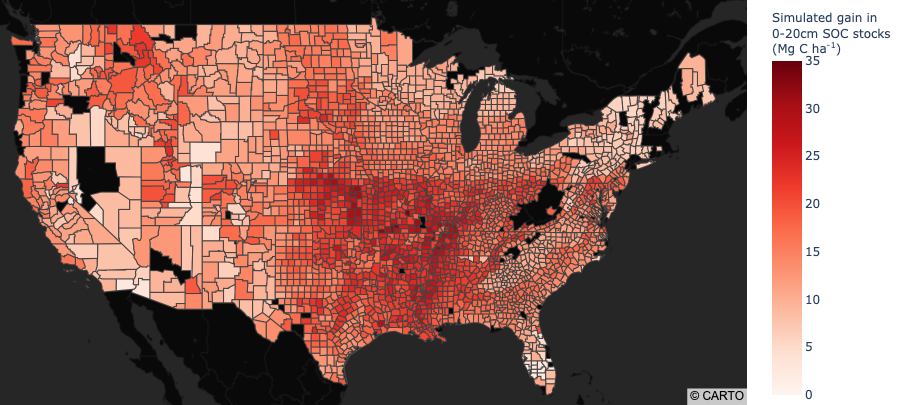

In [82]:
mapping(county_df, 'SOCgain_MgC_per_ha', 'Reds', 'Simulated gain in<br>0-20cm SOC stocks<br>(Mg C ha<sup>-1</sup>)',
    kwargs={"range_color": [0, 35]})

In [61]:
# explore SOC vs. peak cropland extent year (i.e., time since abanonment)

# merge in peak cropland year data
county_df = county_df.merge(peak_df, on='fips')

# bin the peak_year into appropriate intervals for boxplot
county_df['peak_year_binned'] = pd.cut(county_df['peak_year'], bins=range(1950, 2000, 5), right=False)
county_df

fips variety        tot_ha   prod_Mt  yield_Mg_per_ha  \
0     01001    base  31214.547584  0.669676        21.453964   
1     01003    base  19794.098716  0.428314        21.638478   
2     01005    base  34348.741190  0.756385        22.020761   
3     01007    base   6070.472827  0.136300        22.452943   
4     01009    base  27967.981922  0.608412        21.753865   
...     ...     ...           ...       ...              ...   
2882  56037    base   2339.515969  0.004297         1.836876   
2883  56039    base   7707.760967  0.076806         9.964753   
2884  56041    base   2241.368860  0.010734         4.788846   
2885  56043    base   3115.660099  0.020330         6.525234   
2886  56045    base  49942.057254  0.305675         6.120595   

      initSOC_MgC_per_ha  SOC_MgC_per_ha  dSOC_MgC_per_ha  dN2ON_kgN_per_ha  \
0              15.861822       33.348176        -0.145183          1.266544   
1              14.308916       29.382646        -0.159278          1.159342   
2              15.007400       32.449582        -0.161873          1.217273   
3              18.788108       38.632229        -0.111036          1.126095   
4              27.973606       49.639504        -0.046419          1.090700   
...                  ...             ...              ...               ...   
2882           11.753413       15.612790         0.027413          0.691059   
2883           44.834972       62.500386         0.119342          2.353930   
2884           26.617103       35.491729         0.076301          1.212981   
2885           31.696533       41.595888         0.077791          1.145751   
2886           23.757367       35.198418         0.116365          1.017300   

      iN2ON_kgN_per_ha  ...  ghg_MgCO2e_per_ha  volit_kgN_per_ha  \
0             0.440938  ...           1.191494         11.630172   
1             0.489524  ...           1.224304         11.695586   
2             0.421534  ...           1.221481         11.974693   
3             0.410996  ...           0.994000         12.108087   
4             0.385527  ...           0.731307         11.729186   
...                ...  ...                ...               ...   
2882          0.055150  ...           0.133653          1.548855   
2883          0.307708  ...           0.631067          5.613527   
2884          0.271912  ...           0.271139          3.068788   
2885          0.186267  ...           0.201938          3.950702   
2886          0.130211  ...          -0.020441          3.775828   

      leached_kgN_per_ha  annual_precip_cm  leach_volit_frac  \
0              41.222530        126.384666          0.704703   
1              47.680970        142.606667          0.791687   
2              38.122601        118.420994          0.667964   
3              36.318255        131.636427          0.645685   
4              33.420151        126.233706          0.601991   
...                  ...               ...               ...   
2882            2.472170         20.506092          0.053614   
2883           30.767979         71.297985          0.485087   
2884           30.245258         34.756267          0.444187   
2885           17.093701         38.533469          0.280592   
2886           10.542336         37.755811          0.190909   

      yield_Mg_per_ha_std  yield_Mg_per_ha_cov  SOCgain_MgC_per_ha  \
0                2.967179             0.138304           17.486355   
1                2.146405             0.099194           15.073730   
2                3.278115             0.148865           17.442182   
3                2.474065             0.110189           19.844120   
4                2.616056             0.120257           21.665898   
...                   ...                  ...                 ...   
2882             1.132577             0.616578            3.859377   
2883             0.924592             0.092786           17.665414   
2884             2.058416             0.429835            8.874626   
288

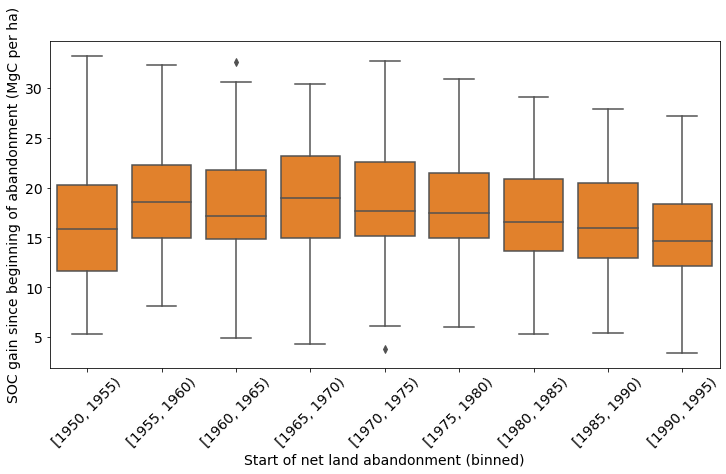

In [62]:
# create box and whisker plot of SOC gain since abandonment

plt.figure(figsize=(12, 6))
sns.boxplot(x='peak_year_binned', y='SOCgain_MgC_per_ha', data=county_df, color='C1')
plt.xlabel('Start of net land abandonment (binned)')
plt.ylabel('SOC gain since beginning of abandonment (MgC per ha)')
plt.xticks(rotation=45)
plt.savefig('03_figure_outputs/SOC_gain-v-abandonment_start.png')
plt.show()

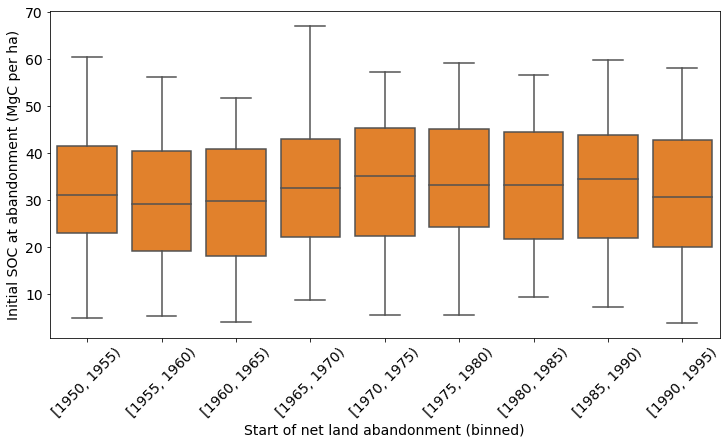

In [63]:
# create box and whisker plot of initial SOC at time of peak cropland extent

plt.figure(figsize=(12, 6))
sns.boxplot(x='peak_year_binned', y='initSOC_MgC_per_ha', data=county_df, color='C1')
plt.xlabel('Start of net land abandonment (binned)')
plt.ylabel('Initial SOC at abandonment (MgC per ha)')
plt.xticks(rotation=45)
plt.savefig('03_figure_outputs/InitialSOC_gain_at_abandonment_start.png')
plt.show()

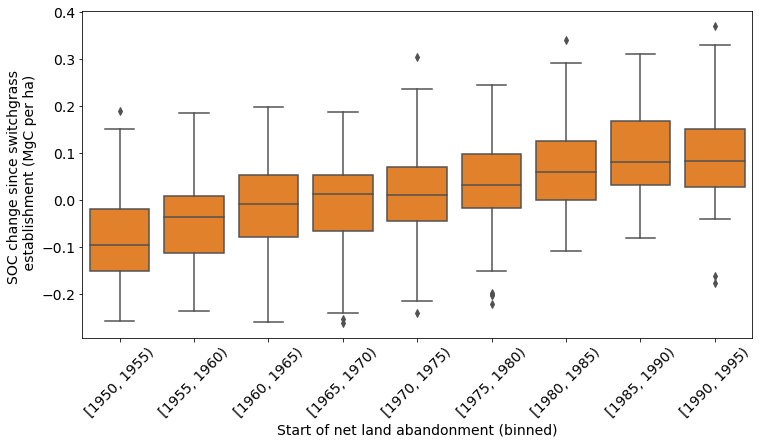

In [64]:
# create box and whisker plot of SOC change since switchgrass establishment

plt.figure(figsize=(12, 6))
sns.boxplot(x='peak_year_binned', y='dSOC_MgC_per_ha', data=county_df, color='C1')
plt.xlabel('Start of net land abandonment (binned)')
plt.ylabel('SOC change since switchgrass \n establishment (MgC per ha)')
plt.xticks(rotation=45)
plt.savefig('03_figure_outputs/dSOC-v-abandonment_start.png')
plt.show()

# Code fragments

In [65]:
# def soil_stats(mukey):

#     soil_cols = ['upper_depth_cm', 'lower_depth_cm', 'BD_g_cm3', 'FC', 'WP', 'evap_coef', 'frac_roots', 'sand', 'clay', 'OM',
#                     'SWCmin', 'ksat_cm_s', 'pH']
#     soils_path = '/Users/53f/Desktop/Local_datasets/IA_soils/'
    
#     # read soils data, and create a dictionary for storing soil property calculation results
#     soil_dir = str(mukey)[:-3]
#     soil_fpath = os.path.join(soils_path, soil_dir, "{}.in".format(mukey))
#     soil_df = pd.read_csv(soil_fpath, names=soil_cols, delimiter='\t')
#     properties = {}

#     # compute individual layer properties
#     soil_df['WHC_cm'] = (soil_df.FC - soil_df.WP) * (soil_df.lower_depth_cm - soil_df.upper_depth_cm)
#     soil_df['sand_cm'] = soil_df.sand * (soil_df.lower_depth_cm - soil_df.upper_depth_cm)
#     soil_df['clay_cm'] = soil_df.clay * (soil_df.lower_depth_cm - soil_df.upper_depth_cm)

#     # extract & record individual properties of interset
#     properties['mukey'] = mukey
    
#     properties['WHC_cm'] = soil_df.WHC_cm.sum()
#     properties['ksat_surf'] = soil_df.ksat_cm_s[0]
#     properties['ksat_min'] = soil_df.ksat_cm_s.min()

#     properties['sand_surf'] = soil_df.sand[0]
#     properties['clay_surf'] = soil_df.clay[0]

#     last_i = soil_df.index[-1]
#     properties['sand_prof'] = soil_df.sand_cm.sum() / soil_df.lower_depth_cm[last_i]
#     properties['clay_prof'] = soil_df.clay_cm.sum() / soil_df.lower_depth_cm[last_i]

#     return properties

## Yield–soil comparison

In [66]:
# # subset & re-merge the data to calculate variety-driven differences in yield & dSOC
# cs_raw_df = cs_df[['fips', 'County', 'ST', 'strata_no', 'variety', 'time', 'NARR_year', 'annual_precip_cm', 'yield_Mg_ha', 'dSOC_MgC_ha']]
# cs_variety_df = cs_raw_df[cs_raw_df.variety == 'base']
# cs_drought_df = cs_raw_df[cs_raw_df.variety == 'drought_tol']
# cs_variety_df = pd.merge(cs_variety_df, cs_drought_df, on=['fips', 'County', 'ST', 'strata_no', 'time', 'NARR_year', 'annual_precip_cm'], 
#                          suffixes=('_base', '_drought_tol'))

# cs_variety_df['variety_yield_gain_Mg_ha'] = cs_variety_df.yield_Mg_ha_drought_tol - cs_variety_df.yield_Mg_ha_base
# cs_variety_df['variety_dSOC_gain_Mg_ha'] = cs_variety_df.dSOC_MgC_ha_drought_tol - cs_variety_df.dSOC_MgC_ha_base
# cs_variety_df.drop(columns=['variety_base', 'variety_drought_tol'], inplace=True)

# # re-associate w/ run_df to get soil & weather IDs for each strata
# cs_variety_df = pd.merge(cs_variety_df, run_df[['strata_no', 'mukey_int', 'gridx', 'gridy', 'latitude', 'peak_year']], on='strata_no')
# cs_variety_df

In [67]:
# # determine soils.in data that should be downloaded for further analysis

# # # count unique SSURGO map units in full case study dataset
# # mukeys = cs_variety_df.mukey_int.unique().tolist()
# # soil_dirs = [str(x)[:-3] for x in mukeys]
# # set(soil_dirs)

# # filter dataset down to a subset with common county, NARR grid, and peak year, to isolate soil effects
# cs_variety_df.value_counts(['fips', 'gridx', 'gridy', 'peak_year'])
# ##fips   gridx  gridy  peak_year
# ##19159  113    207    1970         2695
# cs_soils_df = cs_variety_df[(cs_variety_df.fips == 19159) & (cs_variety_df.gridx == 113) & (cs_variety_df.gridy == 207) & (cs_variety_df.peak_year == 1970)]
# unique_soils = cs_soils_df.mukey_int.unique()
# unique_soils

In [68]:
# # loop through case study subset mukeys, run soil property function, and store results in a nested list

# soil_data = [['mukey_int', 'WHC_cm', 'ksat_surf', 'ksat_min', 'sand_surf', 'clay_surf', 'sand_prof', 'clay_prof']]
# for mukey in unique_soils:
#     soil_props = soil_stats(mukey)
#     soil_data.append(list(soil_props.values()))

# # convert nested results list to a DataFrame, and merge with case study subset DataFrame
# soil_props_df = pd.DataFrame(soil_data[1:], columns=soil_data[0])
# soil_props_df

# cs_soils_df = pd.merge(cs_soils_df, soil_props_df, on='mukey_int', how='left')
# cs_soils_df

In [69]:
# ids = "_" + base_sims.split("_")[0] + "_" + drought_sims.split("_")[0]

# fig1, ax1 = plt.subplots()
# ax1 = cs_soils_df.plot.scatter(x='annual_precip_cm', y='yield_Mg_ha_base', c='WHC_cm', colormap='viridis', ax=ax1)
# fig1.savefig("Base_yield-vs-precip-by-WHC" + ids + ".pdf")

In [70]:
# fig2, ax2 = plt.subplots()
# ax2 = cs_soils_df.plot.scatter(x='WHC_cm', y='variety_yield_gain_Mg_ha', c='annual_precip_cm', colormap='viridis', ax=ax2)
# ax2.axhline(color='k')
# fig2.savefig("Yield_gain-vs-WHC-by-precip" + ids + ".pdf")

In [71]:
# ssurgo_metadata_fpath = '/Users/johnfield/Desktop/GCEP_local/ssurgo2012_texture_depth.csv'
# soil_df = pd.read_csv(ssurgo_metadata_fpath)

# cs_soil_df = pd.merge(cs_soil_df[['strata_no', 'time', 'yield_Mg_ha']],
#                       run_df[['strata_no', 'mukey_int', 'peak_year']],
#                       on='strata_no')
# cs_soil_df = pd.merge(cs_soil_df, soil_df, left_on='mukey_int', right_on='mukey')

# cs_soil_df['peak_year'].value_counts()
# # cs_soil_df.hist(column='peak_year')

# cs_soil_df.plot.scatter(x='depth', y='yield_Mg_ha')

## Climate analysis
Here's some initial exploratory code to parse a DayCent-format weather file and analyze inter-annual variability in growing-season temperatures and precipitation.

In [72]:
# weather_file1 = "NARR_89_234.wth"
# weather_df1 = pd.read_csv(weather_file1, sep='\t', usecols=range(1, 7),
#                          names=['DayOfMonth','Month', "Year", "DayOfYear", 'Tmax_C', 'Tmin_C', "Precip_cm"])
# weather_file2 = "NARR_89_231.wth"
# weather_df2 = pd.read_csv(weather_file2, sep='\t', usecols=range(1, 7),
#                          names=['DayOfMonth','Month', "Year", "DayOfYear", 'Tmax_C', 'Tmin_C', "Precip_cm"])
# weather_df2

In [73]:
# wth_df = pd.merge(weather_df1, weather_df2, on=['Month', 'Year', 'DayOfYear'], suffixes=['_234', '_231'])
# seasonal_wth_df = wth_df[wth_df['Month'].isin([5, 6, 7, 8, 9])]
# seasonal_wth_df['Tavg_C_231'] = (seasonal_wth_df['Tmin_C_231'] + seasonal_wth_df['Tmax_C_231']) / 2.0
# seasonal_wth_df['Tavg_C_234'] = (seasonal_wth_df['Tmin_C_234'] + seasonal_wth_df['Tmax_C_234']) / 2.0
# annunal_wth_df = seasonal_wth_df.groupby('Year').agg({'Tmax_C_231': 'mean',
#                                                       'Tavg_C_231': 'mean',
#                                                       'Precip_cm_231': 'sum',
#                                                       'Tmax_C_234': 'mean',
#                                                       'Tavg_C_234': 'mean',
#                                                       'Precip_cm_234': 'sum'})
# annunal_wth_df['Precip_diff_cm'] = annunal_wth_df['Precip_cm_231'] - annunal_wth_df['Precip_cm_234']
# annunal_wth_df.head()

In [74]:
# fig = plt.figure()
# spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[1, 2])
# fig.suptitle("Difference between two weather grid centroids, 100km apart")

# ax0 = fig.add_subplot(spec[0])
# ax0.bar(annunal_wth_df.index, annunal_wth_df.Precip_diff_cm)
# plt.setp(ax0.get_xticklabels(), visible=False)
# plt.ylabel("Difference (cm)")

# ax1 = fig.add_subplot(spec[1], sharex=ax0)
# ax1.plot(annunal_wth_df.Precip_cm_231)
# ax1.plot(annunal_wth_df.Precip_cm_234)
# plt.xlabel("Year")
# plt.ylabel("May–Sept. total precip (cm)")

In [75]:
# plt.scatter(annunal_wth_df.Tavg_C_231, annunal_wth_df.Precip_cm_231)
# plt.title("Inter-annual variability in growing season weather")
# plt.xlabel("May–Sept. average air temperature (C)")
# plt.ylabel("May–Sept. total precipitation (cm)")

In [76]:
# print total notebook execution time

end_time = datetime.now()
print('Notebook execution duration: {}'.format(end_time - start_time))

Notebook execution duration: 0:10:16.035537
